In [7]:
import pandas as pd
from IPython.display import display, HTML
%load_ext autoreload
%autoreload 2

import importlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
csv_file = open("Data/uaScoresDataFrame.csv")
scores = pd.read_csv(csv_file)
scores = scores.drop('id', axis=1)
scores = scores.drop('Venture Capital', axis=1)

In [9]:
def check_zero(dataset):
    invalid_rows = []
    for element in dataset.columns.tolist():
        invalid = dataset[dataset[element] == 0.0]
        invalid_rows.append(invalid[['UA_Name','UA_Country']])
    df = pd.concat(invalid_rows).reset_index(drop=True).value_counts()
    return df
results = check_zero(scores).to_frame().reset_index().rename(columns={0:"number"})
print(results)

                       UA_Name               UA_Country  number
0                      Andorra                  Andorra       6
1                    Gibraltar                Gibraltar       5
2                      Managua                Nicaragua       3
3                     Tashkent               Uzbekistan       3
4                  Belize City                   Belize       3
5                       Panama                   Panama       3
6                    Palo Alto               California       2
7                       La Paz                  Bolivia       2
8                     Portland                    Maine       2
9                       Havana                     Cuba       2
10                     Fukuoka                    Japan       2
11                    San Juan              Puerto Rico       2
12                     Bozeman                  Montana       2
13                   Baltimore                 Maryland       2
14                    Valletta          

In [10]:
scores = scores[(scores != 0).all(1)]

In [11]:
weights_data = {
    'Housing' : 1.5,
    'Cost of Living' : 1.5,
    'Startups' : 0.5,
    'Business Freedom' : 0.8,
    'Safety' : 1.5,
    'Healthcare' : 1.5,
    'Education' : 0.5,
    'Travel Connectivity' : 1.5,
}

weights_vector = pd.Series(0.0, index=scores.columns[3:-1])
for i in range(len(weights_vector)):
    row_name = weights_vector.index[i]
    weights_vector[i] = weights_data.get(row_name, 1)

In [12]:
summable_values = list(scores)
if 'Naive Sum' in summable_values:
    summable_values.remove('Naive Sum')
weighted_scores = scores.copy()
weighted_scores = weighted_scores * weights_vector
scores['Naive Sum'] = weighted_scores[summable_values].sum(numeric_only=True, axis=1)

In [13]:
# scores['Naive Sum']
# better, worse

midpoint = scores['Naive Sum'].quantile()
scores['Label'] = ''
scores.loc[scores['Naive Sum'] < midpoint, 'Label'] = 'worse'
scores.loc[scores['Naive Sum'] >= midpoint, 'Label'] = 'better'
scores.drop(labels=['Startups', 'Business Freedom', 'Tolerance', 'Outdoors'], axis=1, inplace=True)
#scores_to_plot = scores[['Housing', 'Cost of Living', 'Safety', 'Healthcare', 'Travel Connectivity', 'Label']]
scores_to_plot = scores[['Commute', 'Education', 'Environmental Quality', 'Economy', 'Taxation', 'Internet Access', 'Leisure & Culture', 'Label']]

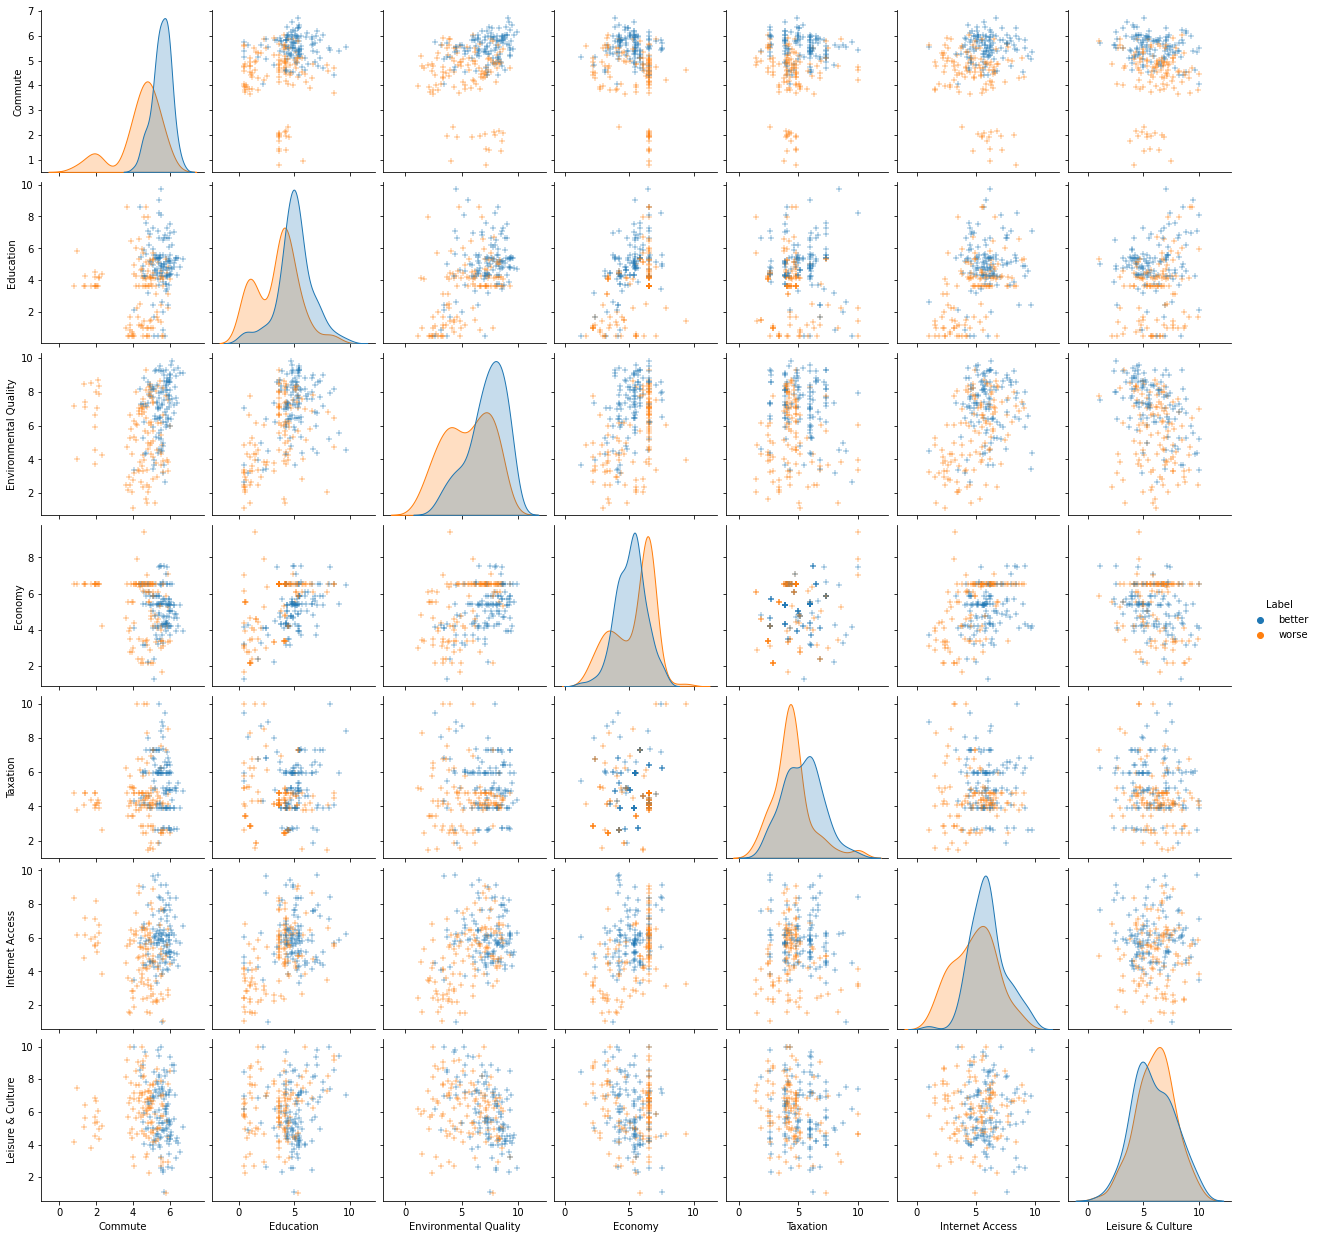

In [14]:
import seaborn as sns

sns.pairplot(scores_to_plot, hue='Label', markers='+')

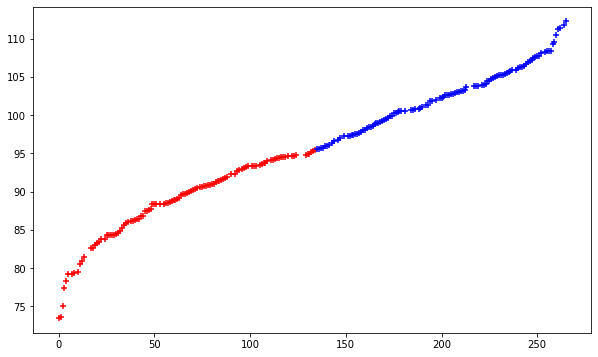

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
vals = scores['Naive Sum'].sort_values()
colors = np.where(vals >= midpoint, 'b', 'r')
ax.scatter(scores.index, vals, c=colors, marker='+')

In [16]:
from Modules.dataprocessing import ProcessingData
ProcessingData.normalize(scores)
a, b = ProcessingData.prepare_data(scores)

preview_table = pd.concat([a.head(), b.head()])

FOR NORM = ZadehNorm, DEFUZZIFICATION METHOD = fom, THRESHOLD = 70


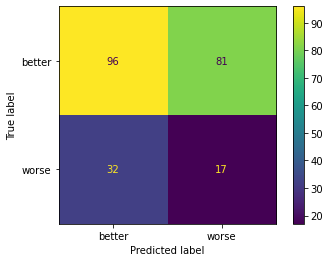

 > accuracy: 78.3%
 > recall: 85.0%
 > specificity: 71.7%
 > precision: 75.0%
----------------------------------------------------------------------------------
FOR NORM = ZadehNorm, DEFUZZIFICATION METHOD = mom, THRESHOLD = 70


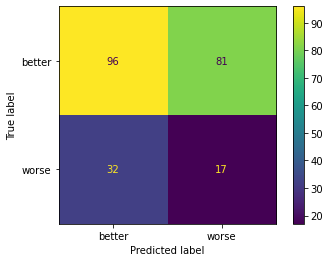

 > accuracy: 78.3%
 > recall: 85.0%
 > specificity: 71.7%
 > precision: 75.0%
----------------------------------------------------------------------------------
FOR NORM = ZadehNorm, DEFUZZIFICATION METHOD = lom, THRESHOLD = 70


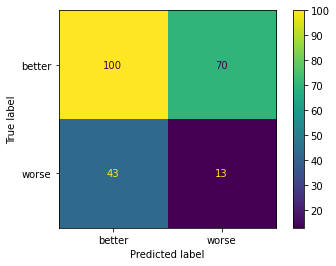

 > accuracy: 75.2%
 > recall: 88.5%
 > specificity: 61.9%
 > precision: 69.9%
----------------------------------------------------------------------------------
FOR NORM = ZadehNorm, DEFUZZIFICATION METHOD = centroid, THRESHOLD = 70


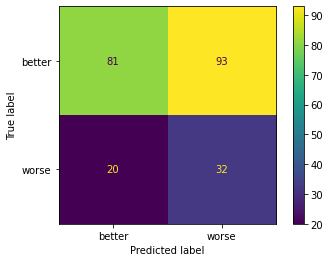

 > accuracy: 77.0%
 > recall: 71.7%
 > specificity: 82.3%
 > precision: 80.2%
----------------------------------------------------------------------------------
FOR NORM = ExtendedMangerNorm, DEFUZZIFICATION METHOD = fom, THRESHOLD = 70


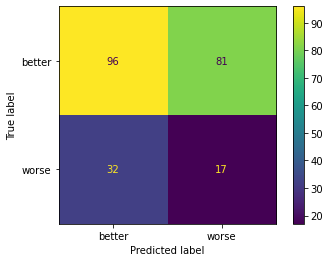

 > accuracy: 78.3%
 > recall: 85.0%
 > specificity: 71.7%
 > precision: 75.0%
----------------------------------------------------------------------------------
FOR NORM = ExtendedMangerNorm, DEFUZZIFICATION METHOD = mom, THRESHOLD = 70


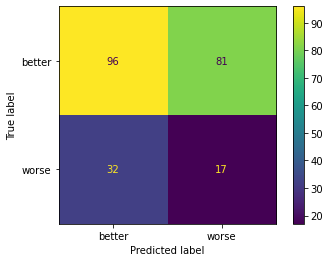

 > accuracy: 78.3%
 > recall: 85.0%
 > specificity: 71.7%
 > precision: 75.0%
----------------------------------------------------------------------------------
FOR NORM = ExtendedMangerNorm, DEFUZZIFICATION METHOD = lom, THRESHOLD = 70


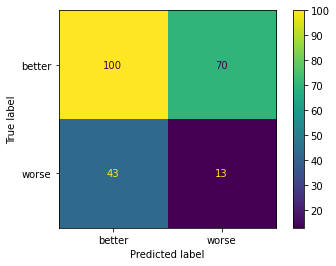

 > accuracy: 75.2%
 > recall: 88.5%
 > specificity: 61.9%
 > precision: 69.9%
----------------------------------------------------------------------------------
FOR NORM = ExtendedMangerNorm, DEFUZZIFICATION METHOD = centroid, THRESHOLD = 70


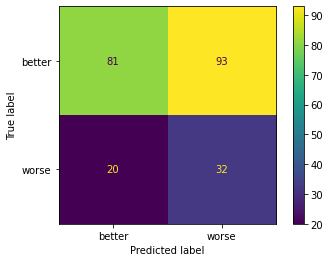

 > accuracy: 77.0%
 > recall: 71.7%
 > specificity: 82.3%
 > precision: 80.2%
----------------------------------------------------------------------------------


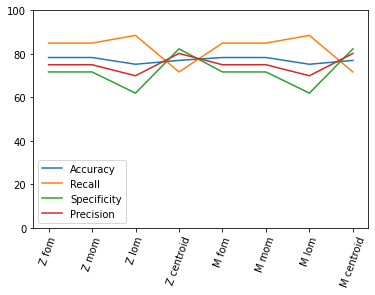

In [17]:
from itertools import product
import Modules.fuzzytesting as test
from Modules.fuzzytesting import FuzzyTest
import warnings
warnings.filterwarnings("ignore")
importlib.reload(test)
import Modules.fuzzysys as fsys
from Modules.norms import ZadehNorm
from Modules.membership_functions import TriangularFunction, TrapezoidalFunction
importlib.reload(fsys)
import Modules.rule as rule
from Modules.rule import RuleCondition as R
importlib.reload(rule)

from Modules.norms import ZadehNorm, ExtendedMangerNorm

Bad = 'Bad'
Average = 'Average'
Good = 'Good'

fuzzy = fsys.FuzzySystem()
fuzzy.add_antecedent('Housing', Bad, TrapezoidalFunction(0, 0, 0.3, 0.55))
fuzzy.add_antecedent('Housing', Average, TriangularFunction(0.5, 0.6, 0.7))
fuzzy.add_antecedent('Housing', Good, TrapezoidalFunction(0.6, 0.8, 1, 1))

fuzzy.add_antecedent('Cost of Living', Bad, TrapezoidalFunction(0, 0, 0.25, 0.47))
fuzzy.add_antecedent('Cost of Living', Average, TriangularFunction(0.4, 0.55, 0.7))
fuzzy.add_antecedent('Cost of Living', Good, TrapezoidalFunction(0.6, 0.75, 1, 1))

fuzzy.add_antecedent('Safety', Bad, TrapezoidalFunction(0, 0, 0.3, 0.6))
fuzzy.add_antecedent('Safety', Average, TriangularFunction(0.5, 0.6, 0.7))
fuzzy.add_antecedent('Safety', Good, TrapezoidalFunction(0.6, 0.8, 1, 1))

fuzzy.add_antecedent('Healthcare', Bad, TrapezoidalFunction(0, 0, 0.25, 0.5))
fuzzy.add_antecedent('Healthcare', Average, TriangularFunction(0.4, 0.6, 0.8))
fuzzy.add_antecedent('Healthcare', Good, TrapezoidalFunction(0.7, 0.85, 1, 1))

fuzzy.add_antecedent('Travel Connectivity', Bad, TrapezoidalFunction(0, 0, 0.14, 0.2))
fuzzy.add_antecedent('Travel Connectivity', Average, TrapezoidalFunction(0.15, 0.25, 0.33, 0.4))
fuzzy.add_antecedent('Travel Connectivity', Good, TrapezoidalFunction(0.35, 0.5, 1, 1))

fuzzy.add_antecedent('Commute', Bad, TrapezoidalFunction(0, 0, 0.46, 0.7))
fuzzy.add_antecedent('Commute', Average, TrapezoidalFunction(0.6, 0.67, 0.74, 0.8))
fuzzy.add_antecedent('Commute', Good, TrapezoidalFunction(0.7, 0.8, 1, 1))

fuzzy.add_antecedent('Education', Bad, TrapezoidalFunction(0, 0, 0.2, 0.4))
fuzzy.add_antecedent('Education', Average, TriangularFunction(0.3, 0.42, 0.5))
fuzzy.add_antecedent('Education', Good, TrapezoidalFunction(0.4, 0.7, 1, 1))

fuzzy.add_antecedent('Environmental Quality', Bad, TrapezoidalFunction(0, 0, 0.25, 0.5))
fuzzy.add_antecedent('Environmental Quality', Average, TriangularFunction(0.45, 0.52, 0.7))
fuzzy.add_antecedent('Environmental Quality', Good, TrapezoidalFunction(0.6, 0.8, 1, 1))

fuzzy.add_antecedent('Economy', Bad, TrapezoidalFunction(0, 0, 0.25, 0.5))
fuzzy.add_antecedent('Economy', Average, TriangularFunction(0.4, 0.5, 0.6))
fuzzy.add_antecedent('Economy', Good, TrapezoidalFunction(0.5, 0.75, 1, 1))

fuzzy.add_antecedent('Taxation', Bad, TrapezoidalFunction(0, 0, 0.26, 0.4))
fuzzy.add_antecedent('Taxation', Average, TrapezoidalFunction(0.3, 0.37, 0.44, 0.5))
fuzzy.add_antecedent('Taxation', Good, TrapezoidalFunction(0.4, 0.6, 1, 1))

fuzzy.add_antecedent('Internet Access', Bad, TrapezoidalFunction(0, 0, 0.2, 0.4))
fuzzy.add_antecedent('Internet Access', Average, TriangularFunction(0.3, 0.45, 0.6))
fuzzy.add_antecedent('Internet Access', Good, TrapezoidalFunction(0.5, 0.75, 1, 1))

fuzzy.add_antecedent('Leisure & Culture', Bad, TrapezoidalFunction(0, 0, 0.25, 0.5))
fuzzy.add_antecedent('Leisure & Culture', Average, TriangularFunction(0.4, 0.52, 0.7))
fuzzy.add_antecedent('Leisure & Culture', Good, TrapezoidalFunction(0.6, 0.8, 1, 1))

fuzzy.add_rule((R('Housing', Good) & R('Cost of Living', Good) & R('Safety', Good)) | (R('Housing', Good) & R('Cost of Living', Good) & R('Healthcare', Good)) | (R('Housing', Good) & R('Cost of Living', Good) & R('Travel Connectivity', Good)) | (R('Housing', Good) & R('Safety', Good) & R('Healthcare', Good)) | (R('Housing', Good) & R('Safety', Good) & R('Travel Connectivity', Good)) | (R('Housing', Good) & R('Healthcare', Good) & R('Travel Connectivity', Good)) | (R('Healthcare', Good) & R('Cost of Living', Good) & R('Safety', Good)) | (R('Travel Connectivity', Good) & R('Cost of Living', Good) & R('Safety', Good)) | (R('Housing', Good) & R('Cost of Living', Good) & R('Safety', Good)) | (R('Healthcare', Good) & R('Cost of Living', Good) & R('Travel Connectivity', Good)) | (R('Safety', Good) & R('Cost of Living', Good) & R('Travel Connectivity', Good)) | (R('Healthcare', Good) & R('Cost of Living', Good) & R('Travel Connectivity', Good)) | (R('Travel Connectivity', Good) & R('Healthcare', Good) & R('Safety', Good)), Good)
fuzzy.add_rule((R('Housing', Average) & R('Cost of Living', Average) & R('Safety', Average)) | (R('Housing', Average) & R('Cost of Living', Average) & R('Healthcare', Average)) | (R('Housing', Average) & R('Cost of Living', Average) & R('Travel Connectivity', Average)) | (R('Housing', Average) & R('Safety', Average) & R('Healthcare', Average)) | (R('Housing', Average) & R('Safety', Average) & R('Travel Connectivity', Average)) | (R('Housing', Average) & R('Healthcare', Average) & R('Travel Connectivity', Average)) | (R('Healthcare', Average) & R('Cost of Living', Average) & R('Safety', Average)) | (R('Travel Connectivity', Average) & R('Cost of Living', Average) & R('Safety', Average)) | (R('Housing', Average) & R('Cost of Living', Average) & R('Safety', Average)) | (R('Healthcare', Average) & R('Cost of Living', Average) & R('Travel Connectivity', Average)) | (R('Safety', Average) & R('Cost of Living', Average) & R('Travel Connectivity', Average)) | (R('Healthcare', Average) & R('Cost of Living', Average) & R('Travel Connectivity', Average)) | (R('Travel Connectivity', Average) & R('Healthcare', Average) & R('Safety', Average)), Average)
fuzzy.add_rule((R('Housing', Bad) & R('Cost of Living', Bad) & R('Safety', Bad)) | (R('Housing', Bad) & R('Cost of Living', Bad) & R('Healthcare', Bad)) | (R('Housing', Bad) & R('Cost of Living', Bad) & R('Travel Connectivity', Bad)) | (R('Housing', Bad) & R('Safety', Bad) & R('Healthcare', Bad)) | (R('Housing', Bad) & R('Safety', Bad) & R('Travel Connectivity', Bad)) | (R('Housing', Bad) & R('Healthcare', Bad) & R('Travel Connectivity', Bad)) | (R('Healthcare', Bad) & R('Cost of Living', Bad) & R('Safety', Bad)) | (R('Travel Connectivity', Bad) & R('Cost of Living', Bad) & R('Safety', Bad)) | (R('Housing', Bad) & R('Cost of Living', Bad) & R('Safety', Bad)) | (R('Healthcare', Bad) & R('Cost of Living', Bad) & R('Travel Connectivity', Bad)) | (R('Safety', Bad) & R('Cost of Living', Bad) & R('Travel Connectivity', Bad)) | (R('Healthcare', Bad) & R('Cost of Living', Bad) & R('Travel Connectivity', Bad)) | (R('Travel Connectivity', Bad) & R('Healthcare', Bad) & R('Safety', Bad)), Bad)
fuzzy.add_rule(((((R('Housing', Good) & ~R('Cost of Living', Good) & ~R('Safety', Good) & ~R('Healthcare', Good) & ~R('Travel Connectivity', Good)) | (~R('Housing', Good) & R('Cost of Living', Good) & ~R('Safety', Good) & ~R('Healthcare', Good) & ~R('Travel Connectivity', Good)) | (~R('Housing', Good) & ~R('Cost of Living', Good) & R('Safety', Good) & ~R('Healthcare', Good) & ~R('Travel Connectivity', Good)) | (~R('Housing', Good) & ~R('Cost of Living', Good) & ~R('Safety', Good) & R('Healthcare', Good) & ~R('Travel Connectivity', Good)) | (~R('Housing', Good) & ~R('Cost of Living', Good) & ~R('Safety', Good) & ~R('Healthcare', Good) & R('Travel Connectivity', Good))) & ((R('Commute', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Internet Access', Good) & R('Leisure & Culture', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Internet Access', Good) & R('Education', Good) & R('Leisure & Culture', Good) & R('Environmental Quality', Good) & R('Taxation', Good)) | (R('Internet Access', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Leisure & Culture', Good)) | (R('Leisure & Culture', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Internet Access', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Internet Access', Good) & R('Leisure & Culture', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Internet Access', Good) & R('Environmental Quality', Good) & R('Leisure & Culture', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Internet Access', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Leisure & Culture', Good)) | (R('Commute', Good) & R('Leisure & Culture', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Internet Access', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Education', Good) & R('Internet Access', Good) & R('Leisure & Culture', Good) & R('Taxation', Good)) & (R('Commute', Good) & R('Education', Good) & R('Internet Access', Good) & R('Economy', Good) & R('Leisure & Culture', Good)) | (R('Commute', Good) & R('Education', Good) & R('Leisure & Culture', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Education', Good) & R('Internet Access', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Internet Access', Good) & R('Leisure & Culture', Good)) | (R('Commute', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Leisure & Culture', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Internet Access', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Leisure & Culture', Good)) | (R('Commute', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Internet Access', Good)) | (R('Commute', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Taxation', Good))))), Good)
fuzzy.add_rule(((((R('Housing', Average) & ~R('Cost of Living', Average) & ~R('Safety', Average) & ~R('Healthcare', Average) & ~R('Travel Connectivity', Average)) | (~R('Housing', Average) & R('Cost of Living', Average) & ~R('Safety', Average) & ~R('Healthcare', Average) & ~R('Travel Connectivity', Average)) | (~R('Housing', Average) & ~R('Cost of Living', Average) & R('Safety', Average) & ~R('Healthcare', Average) & ~R('Travel Connectivity', Average)) | (~R('Housing', Average) & ~R('Cost of Living', Average) & ~R('Safety', Average) & R('Healthcare', Average) & ~R('Travel Connectivity', Average)) | (~R('Housing', Average) & ~R('Cost of Living', Average) & ~R('Safety', Average) & ~R('Healthcare', Average) & R('Travel Connectivity', Average))) & ((R('Commute', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Internet Access', Average) & R('Leisure & Culture', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Internet Access', Average) & R('Education', Average) & R('Leisure & Culture', Average) & R('Environmental Quality', Average) & R('Taxation', Average)) | (R('Internet Access', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Leisure & Culture', Average)) | (R('Leisure & Culture', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Internet Access', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Internet Access', Average) & R('Leisure & Culture', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Internet Access', Average) & R('Environmental Quality', Average) & R('Leisure & Culture', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Internet Access', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Leisure & Culture', Average)) | (R('Commute', Average) & R('Leisure & Culture', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Internet Access', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Education', Average) & R('Internet Access', Average) & R('Leisure & Culture', Average) & R('Taxation', Average)) & (R('Commute', Average) & R('Education', Average) & R('Internet Access', Average) & R('Economy', Average) & R('Leisure & Culture', Average)) | (R('Commute', Average) & R('Education', Average) & R('Leisure & Culture', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Education', Average) & R('Internet Access', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Internet Access', Average) & R('Leisure & Culture', Average)) | (R('Commute', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Leisure & Culture', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Internet Access', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Leisure & Culture', Average)) | (R('Commute', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Internet Access', Average)) | (R('Commute', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Taxation', Average))))), Average)
fuzzy.add_rule(((((R('Housing', Bad) & ~R('Cost of Living', Bad) & ~R('Safety', Bad) & ~R('Healthcare', Bad) & ~R('Travel Connectivity', Bad)) | (~R('Housing', Bad) & R('Cost of Living', Bad) & ~R('Safety', Bad) & ~R('Healthcare', Bad) & ~R('Travel Connectivity', Bad)) | (~R('Housing', Bad) & ~R('Cost of Living', Bad) & R('Safety', Bad) & ~R('Healthcare', Bad) & ~R('Travel Connectivity', Bad)) | (~R('Housing', Bad) & ~R('Cost of Living', Bad) & ~R('Safety', Bad) & R('Healthcare', Bad) & ~R('Travel Connectivity', Bad)) | (~R('Housing', Bad) & ~R('Cost of Living', Bad) & ~R('Safety', Bad) & ~R('Healthcare', Bad) & R('Travel Connectivity', Bad))) & ((R('Commute', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Internet Access', Bad) & R('Leisure & Culture', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Internet Access', Bad) & R('Education', Bad) & R('Leisure & Culture', Bad) & R('Environmental Quality', Bad) & R('Taxation', Bad)) | (R('Internet Access', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Leisure & Culture', Bad)) | (R('Leisure & Culture', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Internet Access', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Internet Access', Bad) & R('Leisure & Culture', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Internet Access', Bad) & R('Environmental Quality', Bad) & R('Leisure & Culture', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Internet Access', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Leisure & Culture', Bad)) | (R('Commute', Bad) & R('Leisure & Culture', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Internet Access', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Internet Access', Bad) & R('Leisure & Culture', Bad) & R('Taxation', Bad)) & (R('Commute', Bad) & R('Education', Bad) & R('Internet Access', Bad) & R('Economy', Bad) & R('Leisure & Culture', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Leisure & Culture', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Internet Access', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Internet Access', Bad) & R('Leisure & Culture', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Leisure & Culture', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Internet Access', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Leisure & Culture', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Internet Access', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Taxation', Bad))))), Bad)
fuzzy.add_rule((((R('Housing', Good) & R('Cost of Living', Good)) | (R('Housing', Good) & R('Safety', Good)) | (R('Housing', Good) & R('Healthcare', Good)) | (R('Housing', Good) & R('Travel Connectivity', Good)) | (R('Cost of Living', Good) & R('Safety', Good)) | (R('Cost of Living', Good) & R('Healthcare', Good)) | (R('Cost of Living', Good) & R('Travel Connectivity', Good)) | (R('Safety', Good) & R('Healthcare', Good)) | (R('Safety', Good) & R('Travel Connectivity', Good)) | (R('Healthcare', Good) & R('Travel Connectivity', Good))) & ((R('Commute', Good) & R('Eduaction', Good)) | (R('Commute', Good) | (R('Environmental Quality', Good)) | (R('Commute', Good) & R('Economy', Good)) | (R('Commute', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Internet Access', Good)) | (R('Commute', Good) & R('Leisure & Culture', Good)) | (R('Education', Good) & R('Environmental Quality', Good)) | (R('Education', Good) & R('Economy', Good)) | (R('Education', Good) & R('Taxation', Good)) | (R('Education', Good) & R('Internet Access', Good)) | (R('Education', Good) & R('Leisure & Culture', Good)) | (R('Environmental Quality', Good) & R('Economy', Good)) | (R('Environmental Quality', Good) & R('Taxation', Good)) | (R('Environmental Quality', Good) & R('Internet Access', Good)) | (R('Commute', Good) & R('Taxation', Good)) | (R('Environmental Quality', Good) & R('Leisure & Culture', Good)) | (R('Economy', Good) & R('Taxation', Good)) | (R('Economy', Good) & R('Internet Access', Good)) | (R('Commute', Good) & R('Taxation', Good)) | (R('Economy', Good) & R('Leisure & Culture', Good)) | (R('Economy', Good) & R('Leisure & Culture', Good)) | (R('Taxation', Good) & R('Internet Access', Good)) | (R('Taxation', Good) & R('Leisure & Culture', Good)) | (R('Internet Access', Good) & R('Leisure & Culture', Good))))), Good)
fuzzy.add_rule((((R('Housing', Average) & R('Cost of Living', Average)) | (R('Housing', Average) & R('Safety', Average)) | (R('Housing', Average) & R('Healthcare', Average)) | (R('Housing', Average) & R('Travel Connectivity', Average)) | (R('Cost of Living', Average) & R('Safety', Average)) | (R('Cost of Living', Average) & R('Healthcare', Average)) | (R('Cost of Living', Average) & R('Travel Connectivity', Average)) | (R('Safety', Average) & R('Healthcare', Average)) | (R('Safety', Average) & R('Travel Connectivity', Average)) | (R('Healthcare', Average) & R('Travel Connectivity', Average))) & ((R('Commute', Average) & R('Eduaction', Average)) | (R('Commute', Average) | (R('Environmental Quality', Average)) | (R('Commute', Average) & R('Economy', Average)) | (R('Commute', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Internet Access', Average)) | (R('Commute', Average) & R('Leisure & Culture', Average)) | (R('Education', Average) & R('Environmental Quality', Average)) | (R('Education', Average) & R('Economy', Average)) | (R('Education', Average) & R('Taxation', Average)) | (R('Education', Average) & R('Internet Access', Average)) | (R('Education', Average) & R('Leisure & Culture', Average)) | (R('Environmental Quality', Average) & R('Economy', Average)) | (R('Environmental Quality', Average) & R('Taxation', Average)) | (R('Environmental Quality', Average) & R('Internet Access', Average)) | (R('Commute', Average) & R('Taxation', Average)) | (R('Environmental Quality', Average) & R('Leisure & Culture', Average)) | (R('Economy', Average) & R('Taxation', Average)) | (R('Economy', Average) & R('Internet Access', Average)) | (R('Commute', Average) & R('Taxation', Average)) | (R('Economy', Average) & R('Leisure & Culture', Average)) | (R('Economy', Average) & R('Leisure & Culture', Average)) | (R('Taxation', Average) & R('Internet Access', Average)) | (R('Taxation', Average) & R('Leisure & Culture', Average)) | (R('Internet Access', Average) & R('Leisure & Culture', Average))))), Average)
fuzzy.add_rule((((R('Housing', Bad) & R('Cost of Living', Bad)) | (R('Housing', Bad) & R('Safety', Bad)) | (R('Housing', Bad) & R('Healthcare', Bad)) | (R('Housing', Bad) & R('Travel Connectivity', Bad)) | (R('Cost of Living', Bad) & R('Safety', Bad)) | (R('Cost of Living', Bad) & R('Healthcare', Bad)) | (R('Cost of Living', Bad) & R('Travel Connectivity', Bad)) | (R('Safety', Bad) & R('Healthcare', Bad)) | (R('Safety', Bad) & R('Travel Connectivity', Bad)) | (R('Healthcare', Bad) & R('Travel Connectivity', Bad))) & ((R('Commute', Bad) & R('Eduaction', Bad)) | (R('Commute', Bad) | (R('Environmental Quality', Bad)) | (R('Commute', Bad) & R('Economy', Bad)) | (R('Commute', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Internet Access', Bad)) | (R('Commute', Bad) & R('Leisure & Culture', Bad)) | (R('Education', Bad) & R('Environmental Quality', Bad)) | (R('Education', Bad) & R('Economy', Bad)) | (R('Education', Bad) & R('Taxation', Bad)) | (R('Education', Bad) & R('Internet Access', Bad)) | (R('Education', Bad) & R('Leisure & Culture', Bad)) | (R('Environmental Quality', Bad) & R('Economy', Bad)) | (R('Environmental Quality', Bad) & R('Taxation', Bad)) | (R('Environmental Quality', Bad) & R('Internet Access', Bad)) | (R('Commute', Bad) & R('Taxation', Bad)) | (R('Environmental Quality', Bad) & R('Leisure & Culture', Bad)) | (R('Economy', Bad) & R('Taxation', Bad)) | (R('Economy', Bad) & R('Internet Access', Bad)) | (R('Commute', Bad) & R('Taxation', Bad)) | (R('Economy', Bad) & R('Leisure & Culture', Bad)) | (R('Economy', Bad) & R('Leisure & Culture', Bad)) | (R('Taxation', Bad) & R('Internet Access', Bad)) | (R('Taxation', Bad) & R('Leisure & Culture', Bad)) | (R('Internet Access', Bad) & R('Leisure & Culture', Bad))))), Bad)
fuzzy.add_consequent(Bad, TriangularFunction(0, 0, 0.4))
fuzzy.add_consequent(Average, TriangularFunction(0.3, 0.5, 0.8))
fuzzy.add_consequent(Good, TriangularFunction(0.7, 1, 1))

#fuzzy.display_antecedents()
#fuzzy.display_consequents()
result = []
fuzzy_test = FuzzyTest(norm=ExtendedMangerNorm(), defuzzification_method='centroid')
for (norm, defuzz_method) in product([ZadehNorm, ExtendedMangerNorm], ['fom', 'mom', 'lom', 'centroid']):
    fuzzy_test = FuzzyTest(norm=norm(), defuzzification_method=defuzz_method)
    result.append(fuzzy_test.run(fuzzy, pd.concat([a, b]), show_confusion_matrix=True))
accuracy = []
recall = []
specificity = []
precision = []
for i in result:
    for j in i.keys():
        if j == 'accuracy':
            accuracy.append(i[j]*100)
        if j == 'recall':
            recall.append(i[j]*100)
        if j == 'specificity':
            specificity.append(i[j]*100)
        if j == 'precision':
            precision.append(i[j]*100)
fig,ax = plt.subplots()
ax.set(ylim=(0,100))
sns.lineplot(x=['Z fom','Z mom', 'Z lom', 'Z centroid','M fom','M mom', 'M lom', 'M centroid'], y=accuracy)
sns.lineplot(x=['Z fom','Z mom', 'Z lom', 'Z centroid','M fom','M mom', 'M lom', 'M centroid'], y=recall)
sns.lineplot(x=['Z fom','Z mom', 'Z lom', 'Z centroid','M fom','M mom', 'M lom', 'M centroid'], y=specificity)
sns.lineplot(x=['Z fom','Z mom', 'Z lom', 'Z centroid','M fom','M mom', 'M lom', 'M centroid'], y=precision)
ax.set_xticklabels(labels=['Z fom','Z mom', 'Z lom', 'Z centroid','M fom','M mom', 'M lom', 'M centroid'], rotation=70)
ax.legend(['Accuracy', 'Recall', 'Specificity', 'Precision'])

In [18]:
import Modules.knn as knn
import Modules.bayes as bayes
accuracy_k, precision_k, recall_k, specificity_k = knn.KNN.knn_for_every_row(a, b, 5, 5, 'Label')
accuracy_b, precision_b, recall_b, specificity_b = bayes.Bayes.bayes(a, b,'Label')


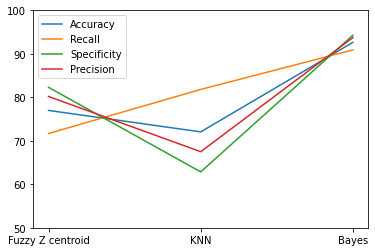

In [19]:
fig,ax = plt.subplots()
ax.set(ylim=(50,100))
sns.lineplot(x=['Fuzzy Z centroid', 'KNN', 'Bayes'], y=[accuracy[3], accuracy_k, accuracy_b])
sns.lineplot(x=['Fuzzy Z centroid', 'KNN', 'Bayes'], y=[recall[3], recall_k, recall_b])
sns.lineplot(x=['Fuzzy Z centroid', 'KNN', 'Bayes'], y=[specificity[3], specificity_k, specificity_b])
sns.lineplot(x=['Fuzzy Z centroid', 'KNN', 'Bayes'], y=[precision[3], precision_k, precision_b])
ax.legend(['Accuracy', 'Recall', 'Specificity', 'Precision'])

Minsk -> 89


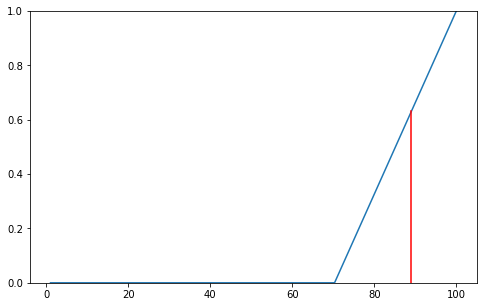

Karlsruhe -> 72


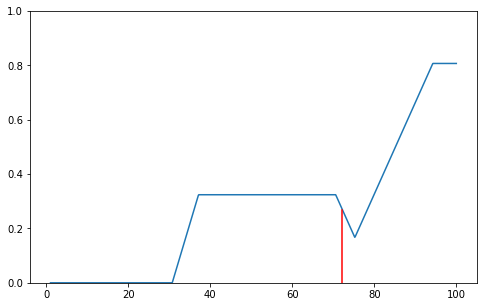

Cambridge -> 89


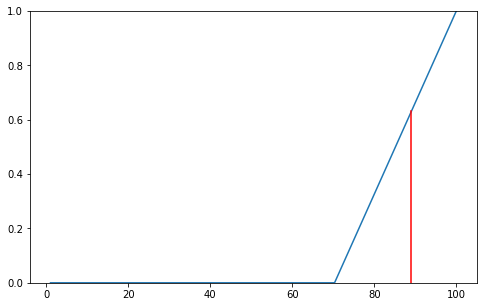

Quebec -> 89


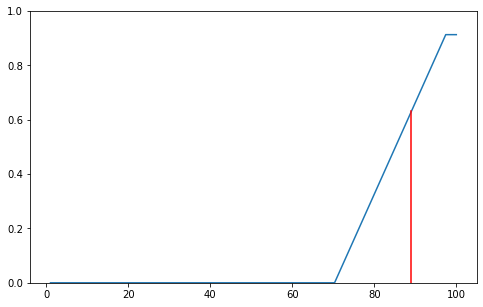

Bilbao -> 71


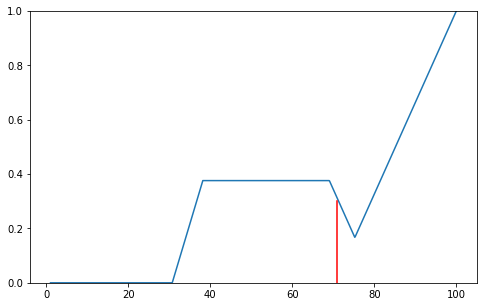

Edmonton -> 62


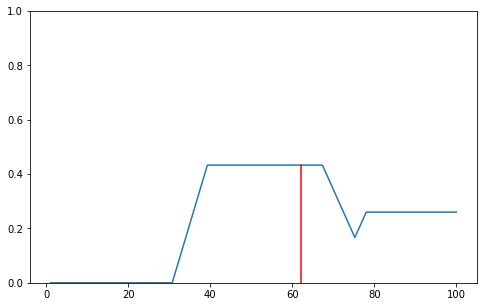

Kuala Lumpur -> 75


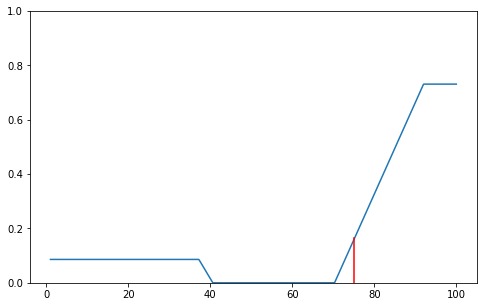

Johannesburg -> 15


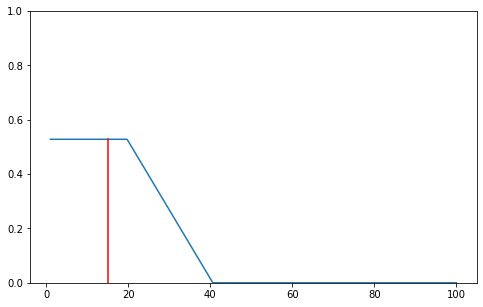

Brighton -> 77


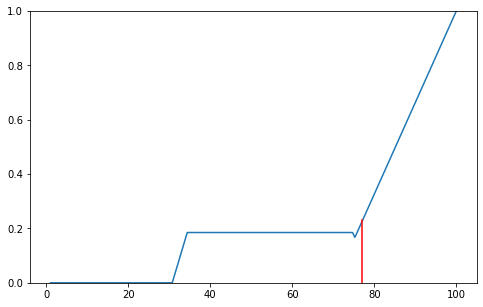

Colorado Springs -> 21


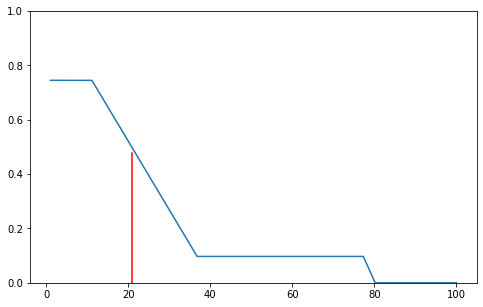

Brisbane -> 76


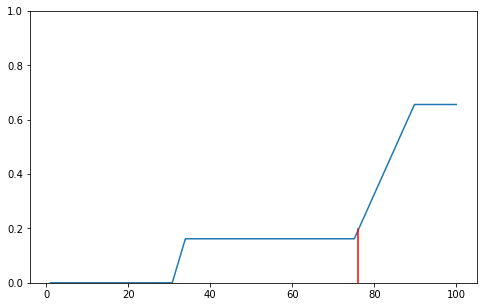

Buffalo -> 85


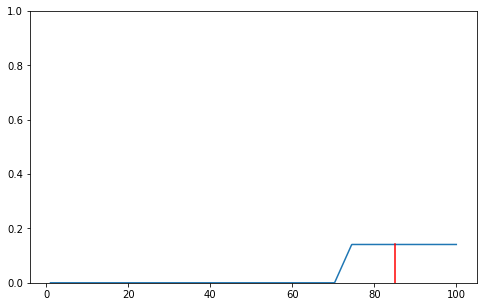

Houston -> 39


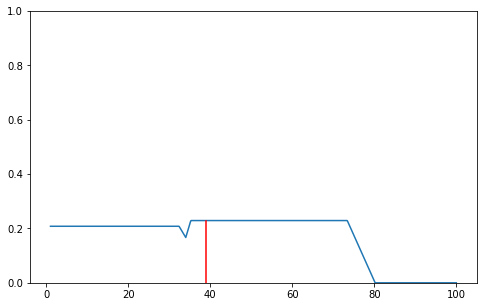

Knoxville -> 35


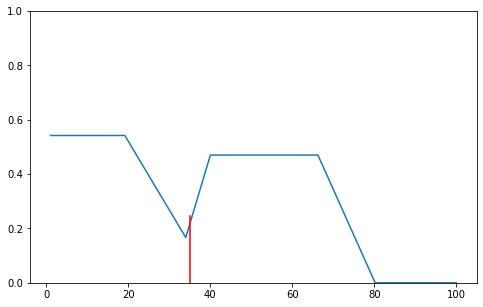

Bergen -> 54


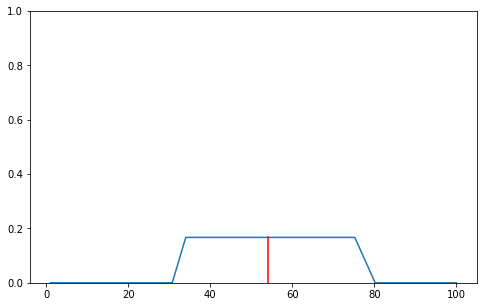

Mexico City -> 54


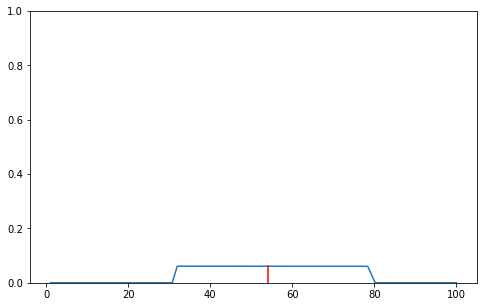

Frankfurt -> 53


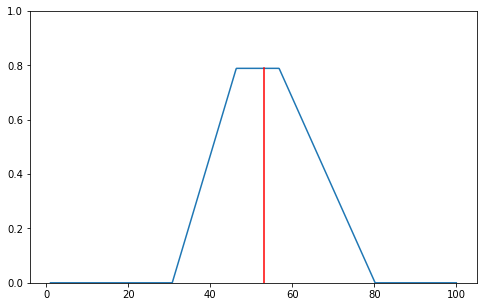

Toronto -> 88


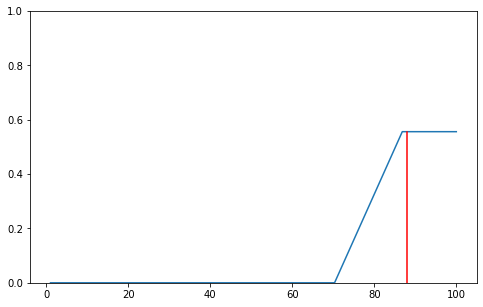

Auckland -> 18


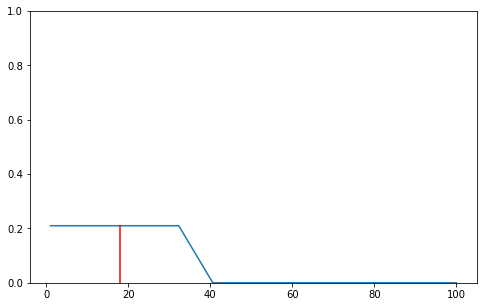

Bengaluru -> 43


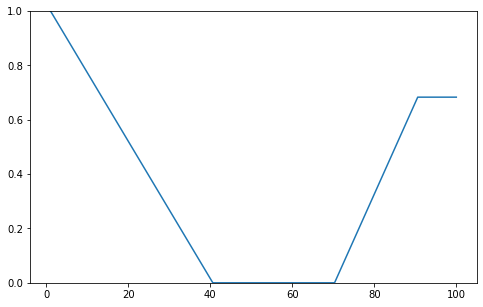

Wroclaw -> 83


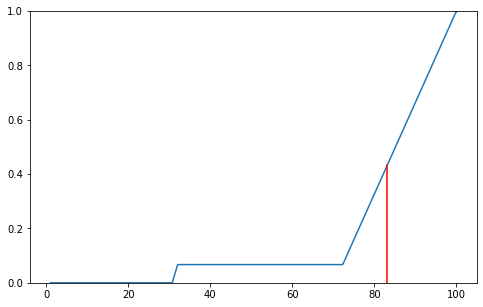

Birmingham -> 33


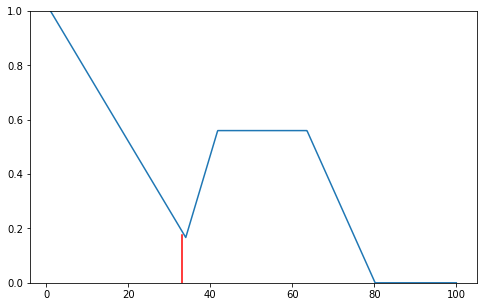

Liverpool -> 89


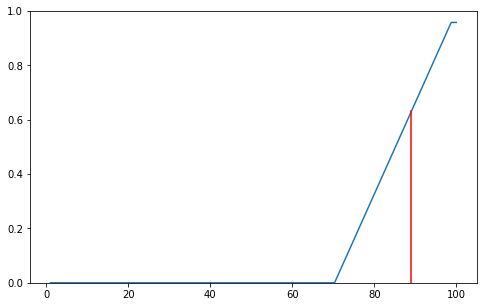

Zagreb -> 89


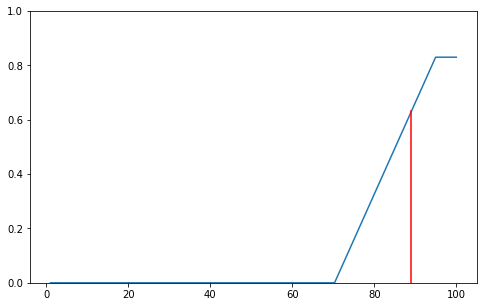

Rochester -> 43


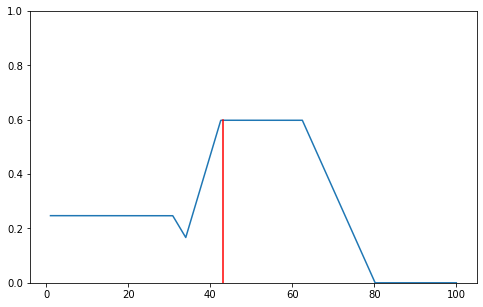

Toulouse -> 88


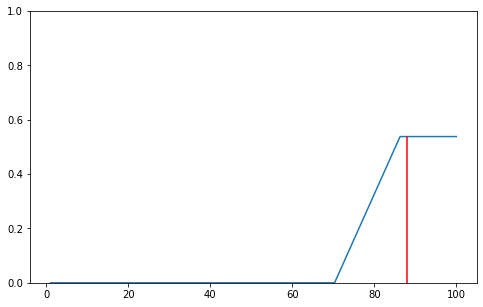

Denver -> 54


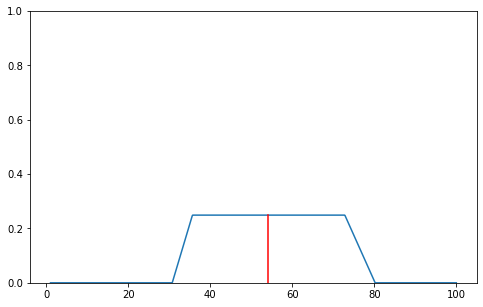

Winnipeg -> 53


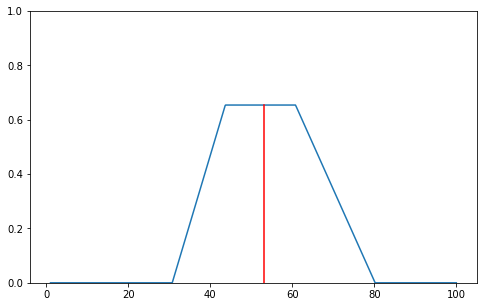

Tokyo -> 89


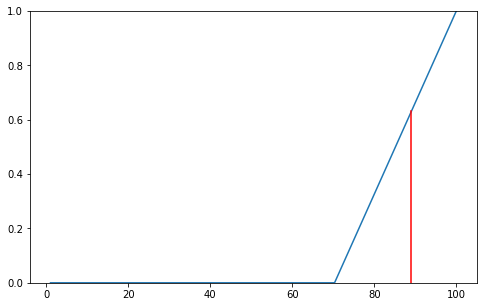

Bologna -> 70


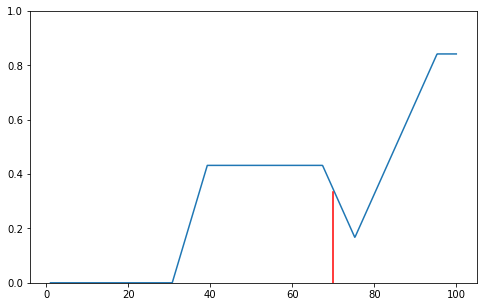

Orlando -> 47


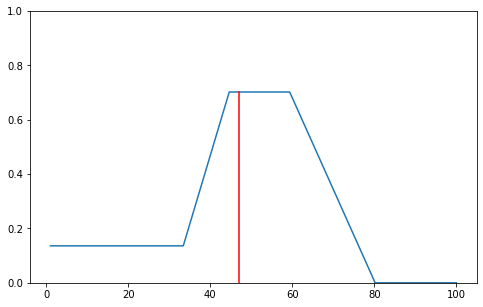

San Jose -> 54


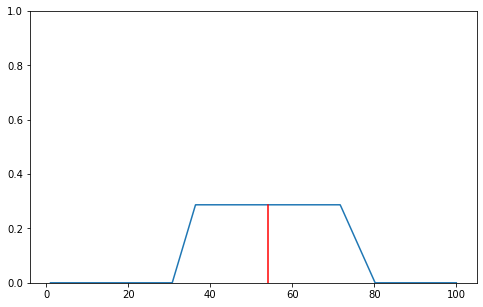

Zurich -> 89


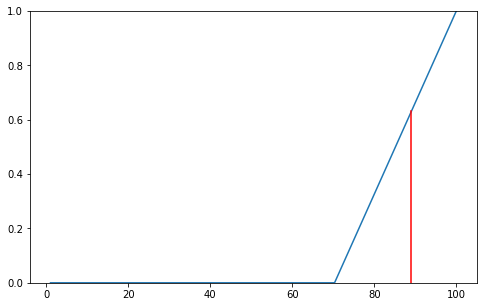

Vienna -> 89


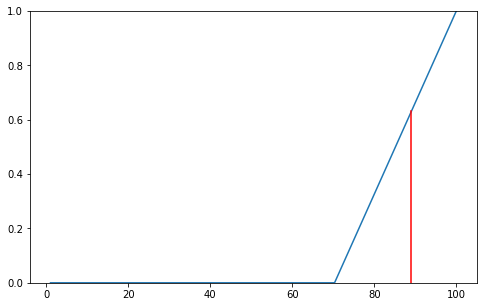

San Diego -> 53


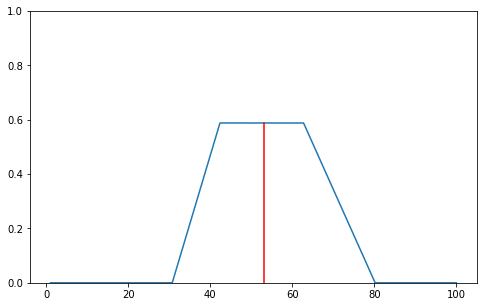

San Francisco Bay Area -> 53


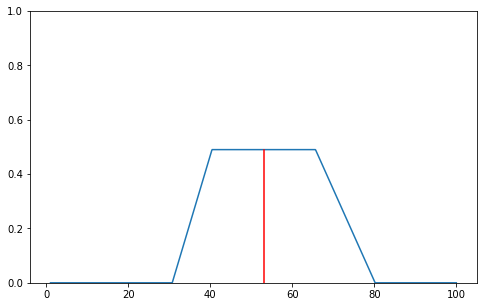

Christchurch -> 81


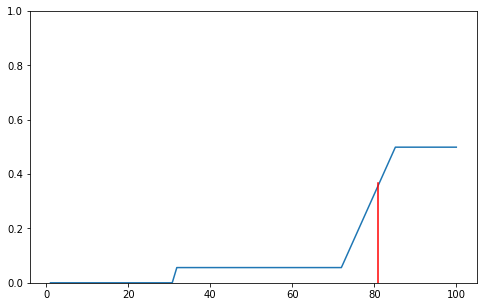

Buenos Aires -> 53


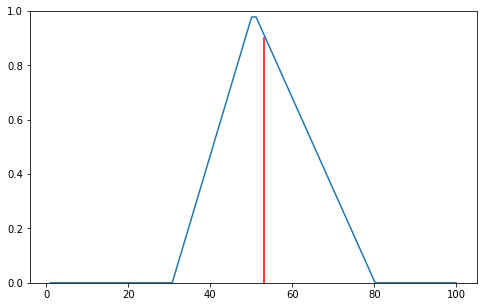

Brussels -> 88


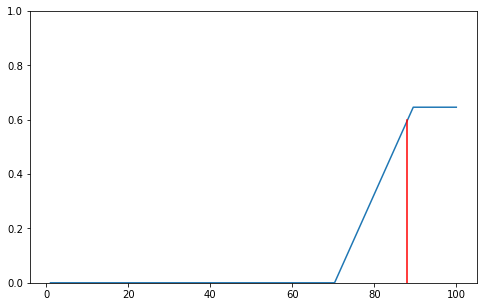

Chattanooga -> 54


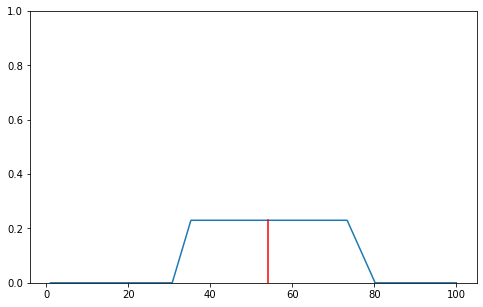

Jacksonville -> 34


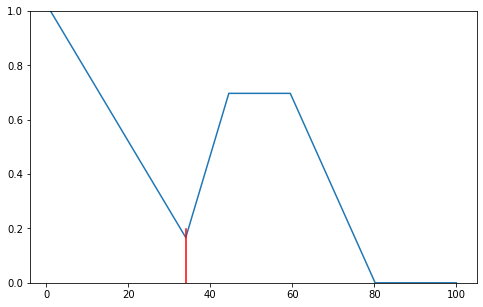

Omaha -> 33


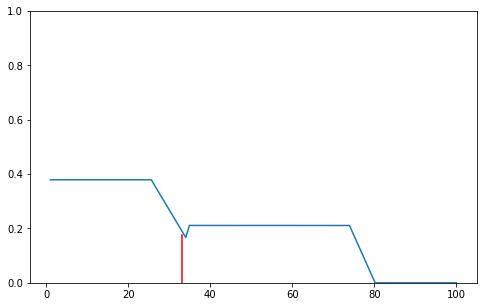

Eugene -> 53


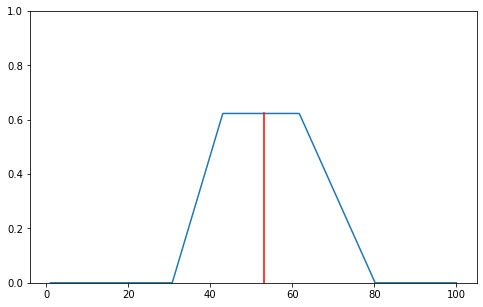

Madison -> 54


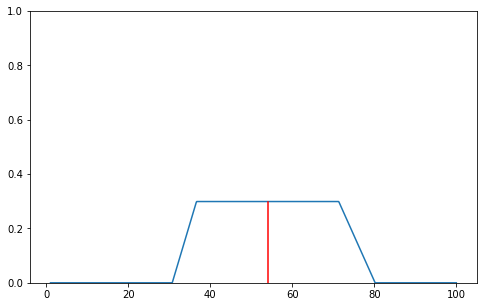

Eindhoven -> 76


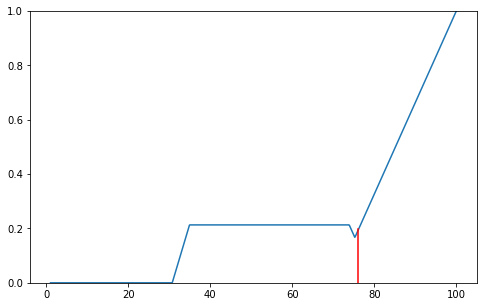

Lausanne -> 89


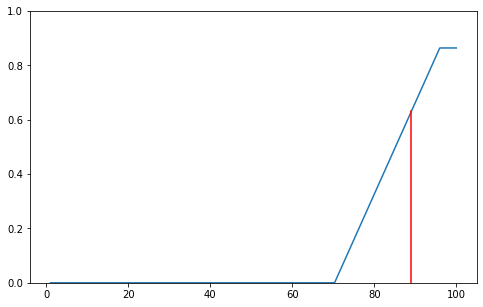

Edinburgh -> 81


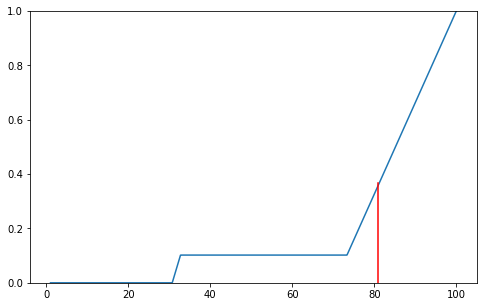

Sofia -> 89


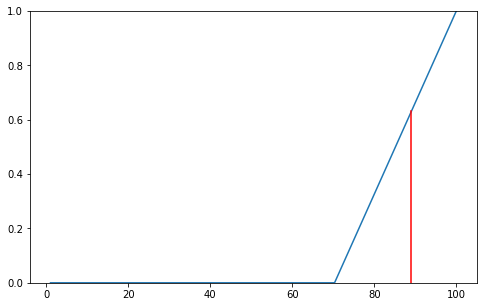

St. Louis -> 53


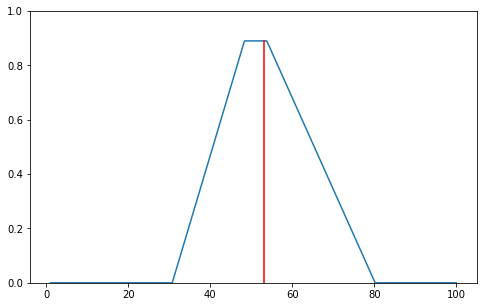

Salt Lake City -> 53


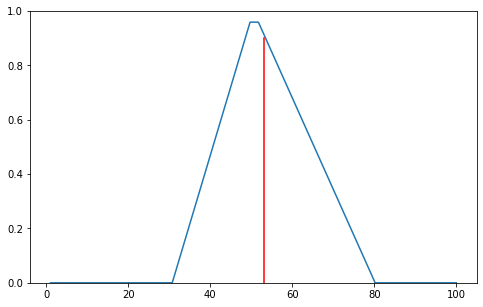

Bangkok -> 70


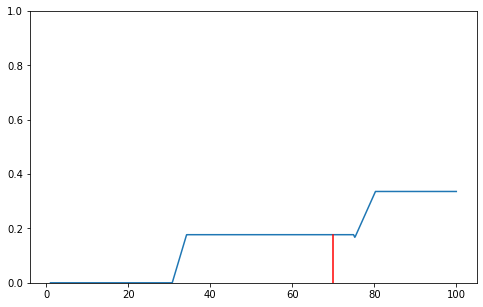

Montreal -> 62


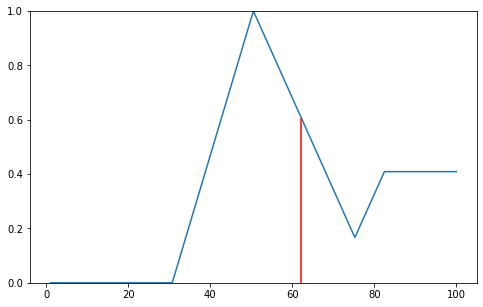

Asheville -> 41


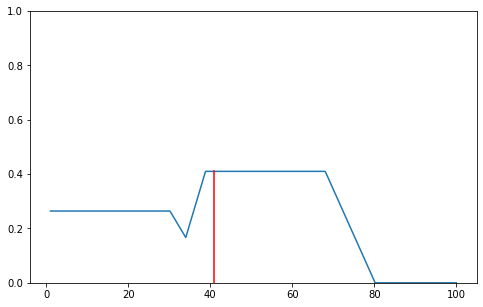

Kansas City -> 29


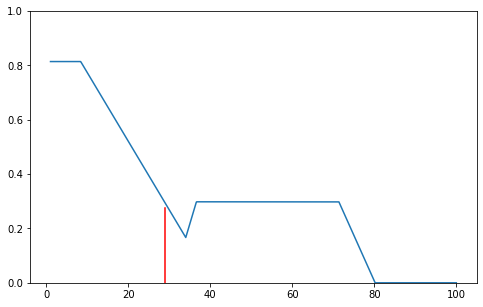

Dubai -> 70


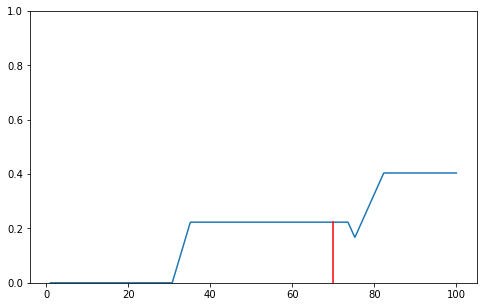

Louisville -> 24


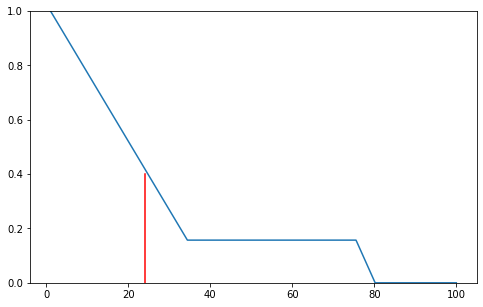

Budapest -> 89


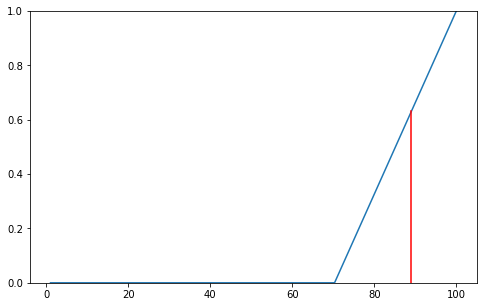

Victoria -> 53


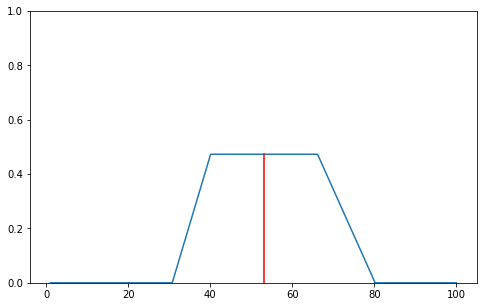

Sydney -> 86


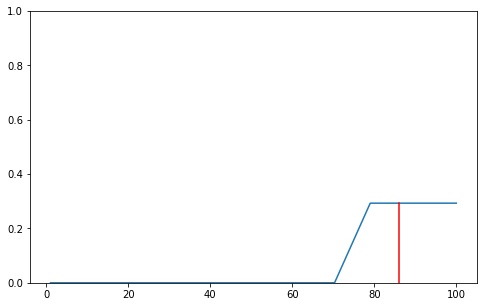

Calgary -> 62


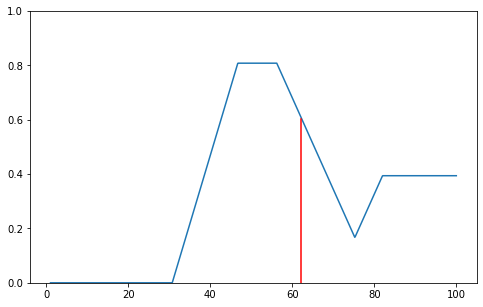

Athens -> 53


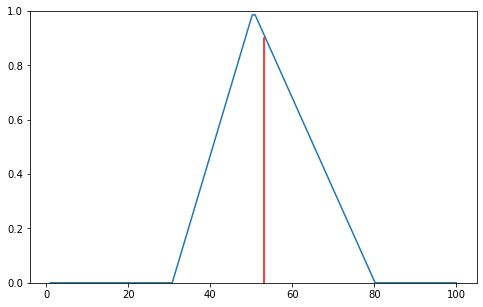

Des Moines -> 53


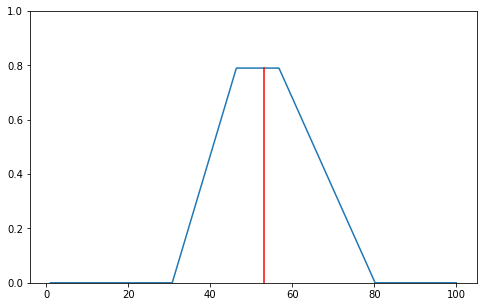

Cleveland -> 35


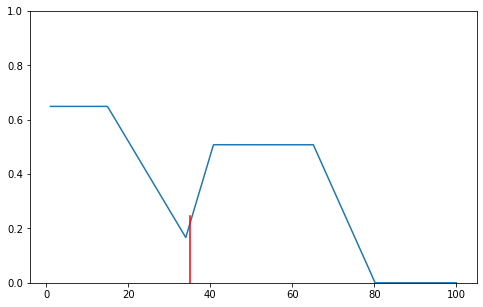

Brno -> 89


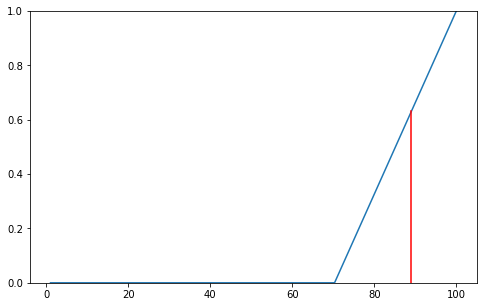

Nice -> 89


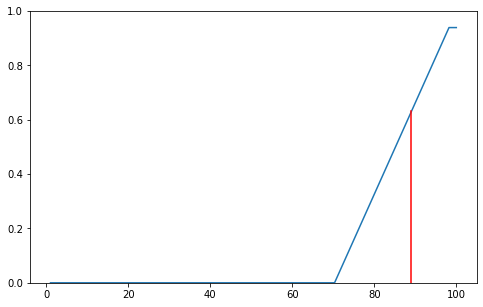

Istanbul -> 89


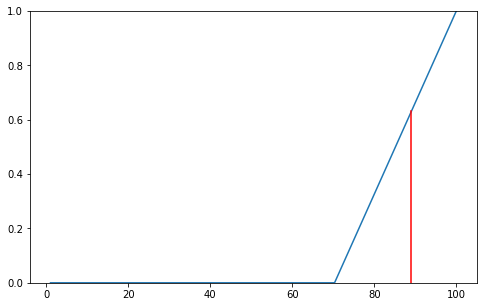

Reykjavik -> 88


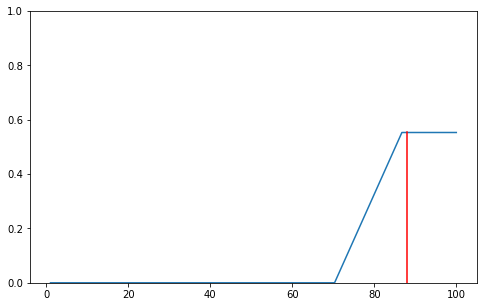

Naples -> 53


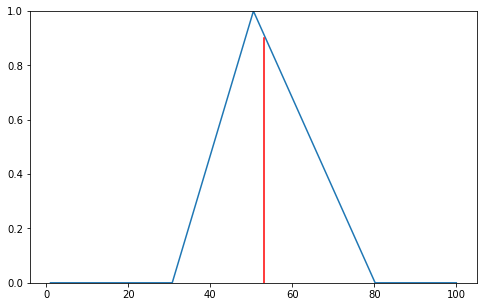

Cologne -> 62


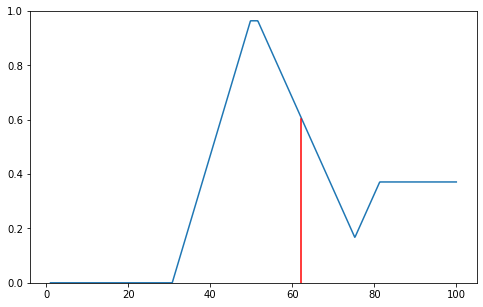

Sao Paulo -> 14


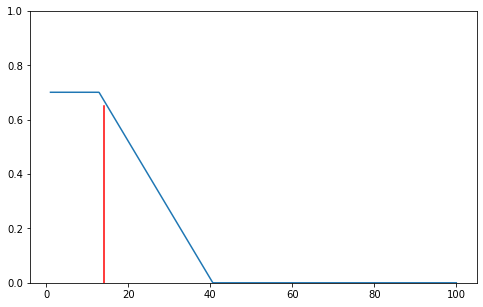

Moscow -> 89


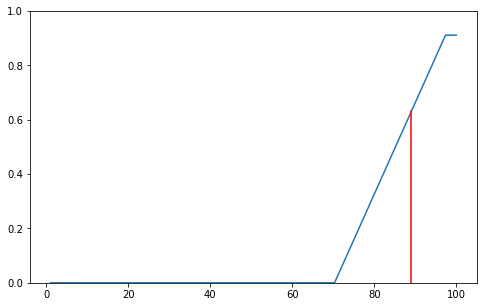

Washington -> 13


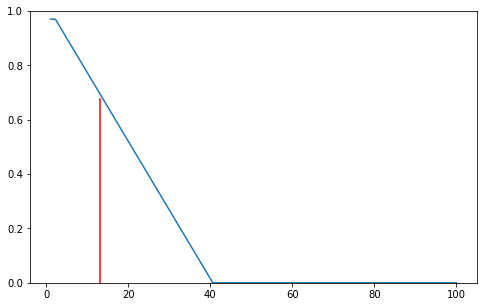

Nairobi -> 19


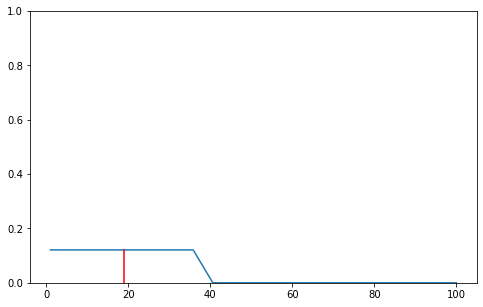

Oslo -> 86


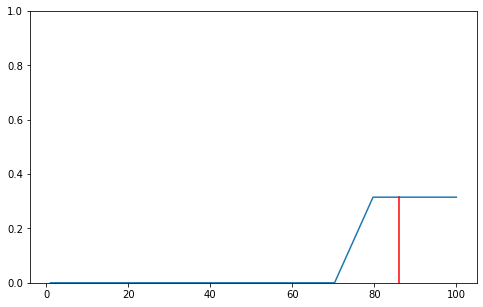

Chennai -> 89


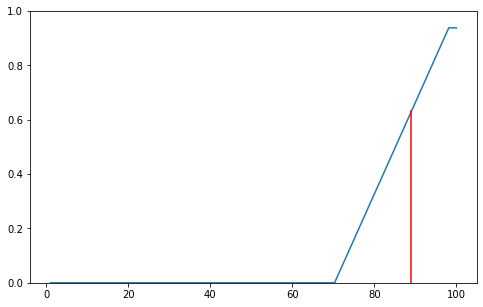

Boston -> 0


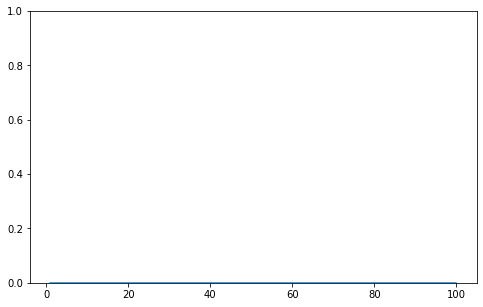

Perth -> 19


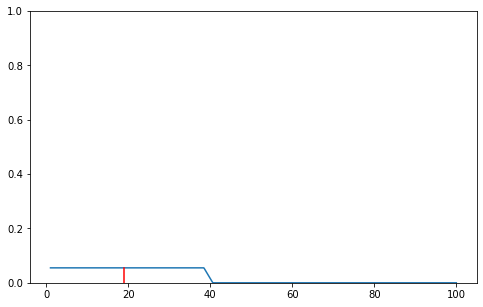

Manchester -> 61


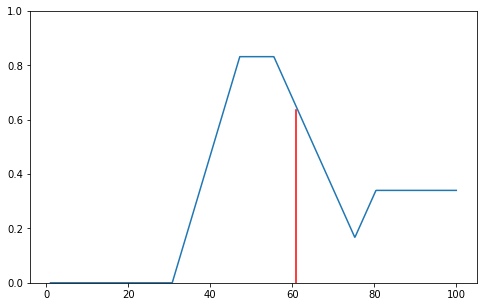

Las Vegas -> 53


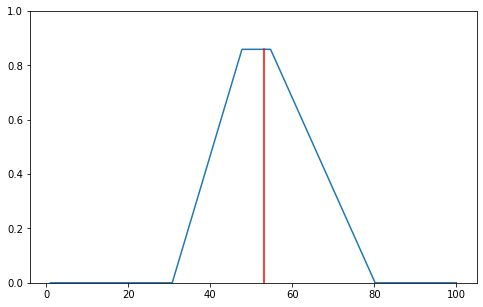

Lille -> 77


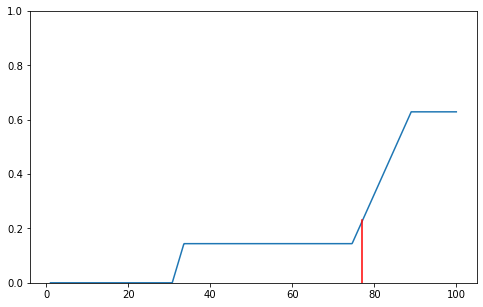

Thessaloniki -> 69


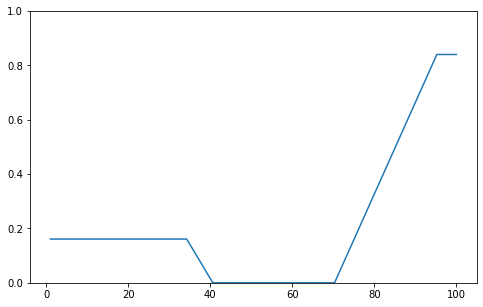

Indianapolis -> 53


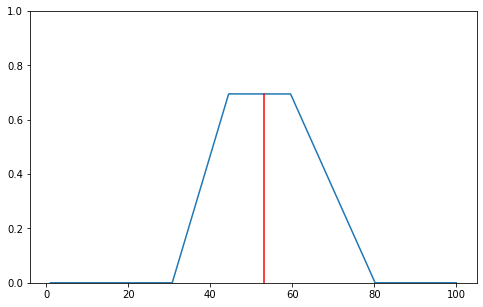

New York -> 0


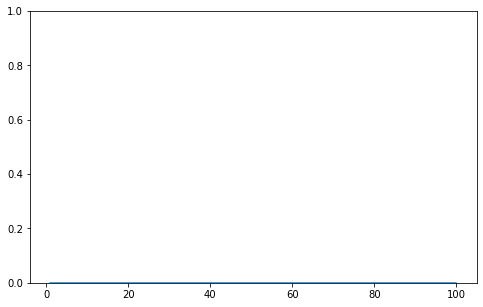

Lyon -> 87


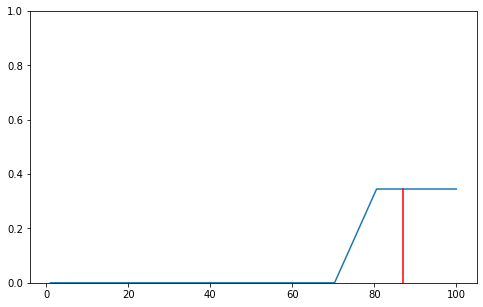

Lisbon -> 67


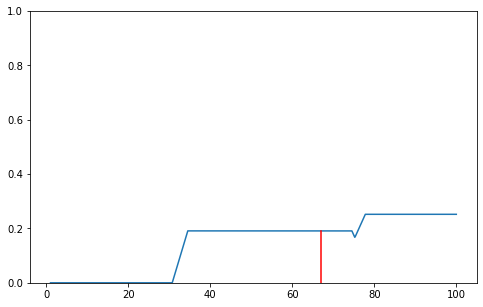

Riga -> 89


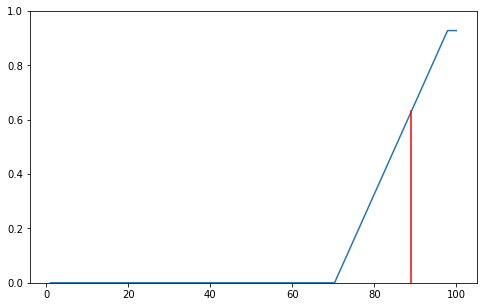

Vancouver -> 64


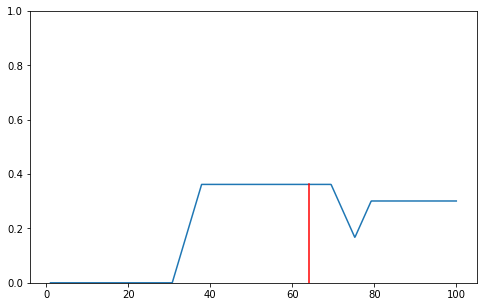

Malmo -> 75


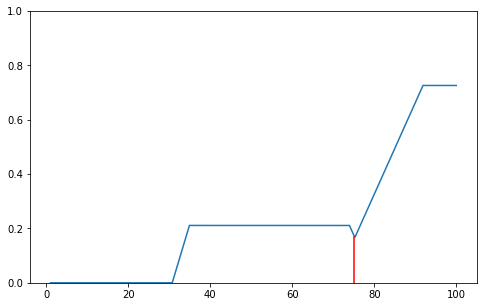

Miami -> 16


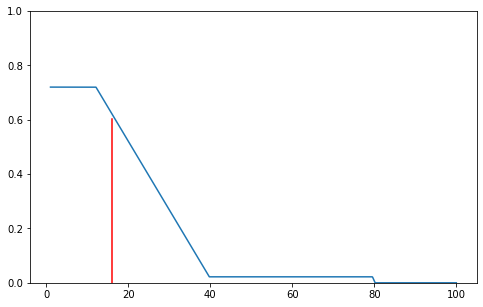

Cairo -> 53


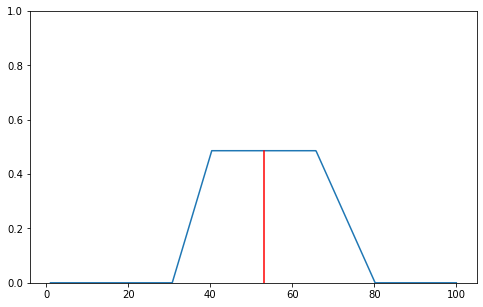

Saskatoon -> 54


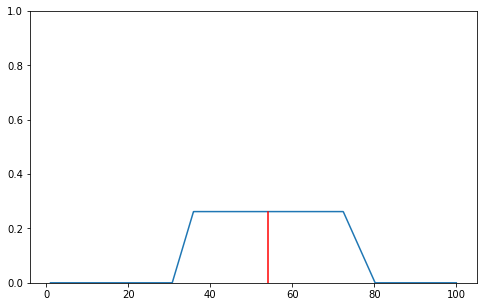

Hong Kong -> 87


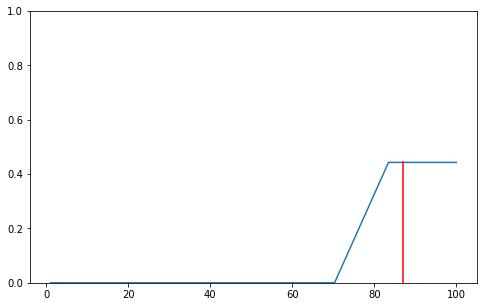

Chisinau -> 46


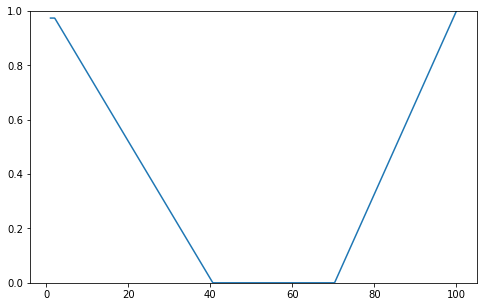

Milwaukee -> 43


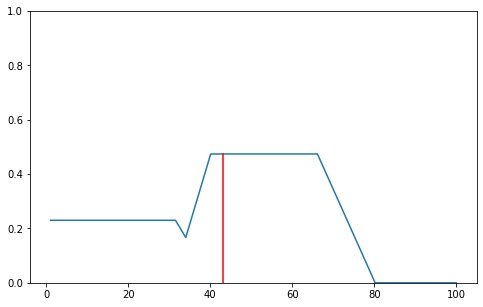

Malaga -> 89


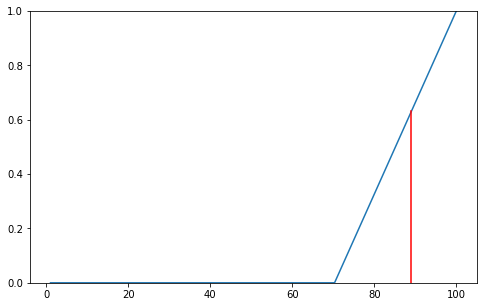

Curitiba -> 55


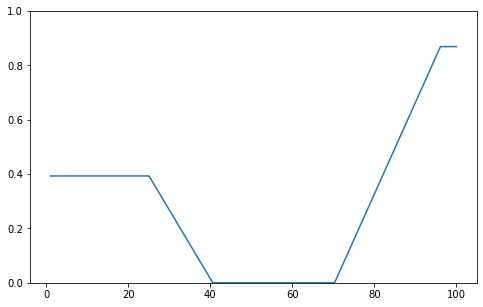

Valencia -> 89


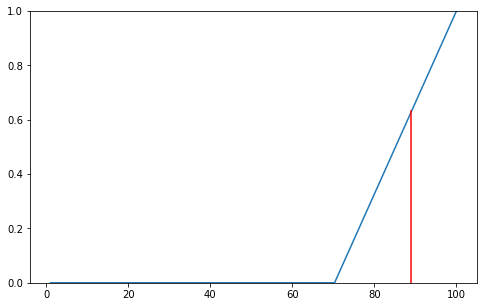

Atlanta -> 15


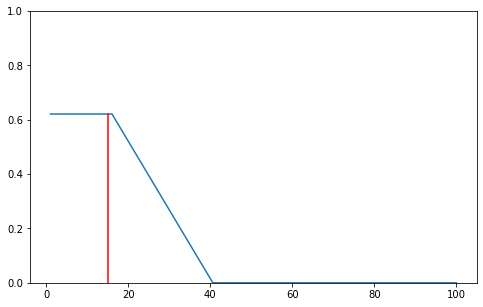

Helsinki -> 89


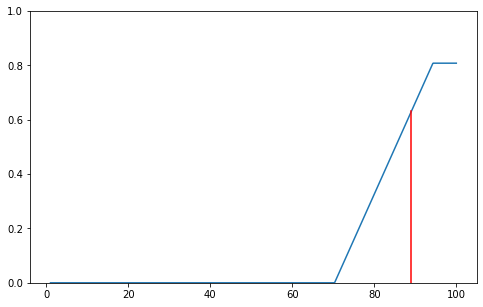

London -> 89


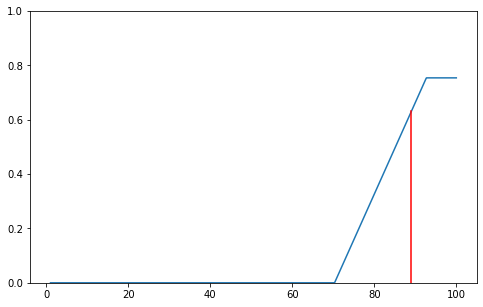

Boise -> 36


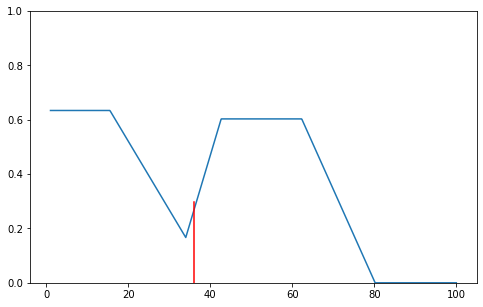

Kiev -> 89


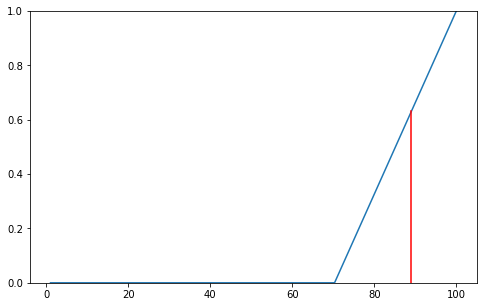

Cork -> 89


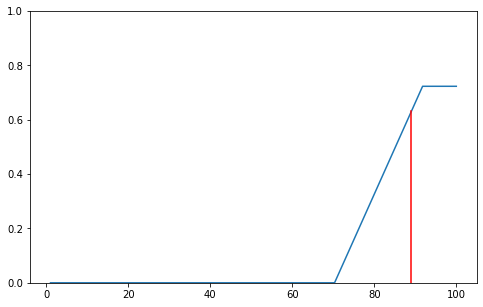

Oklahoma City -> 18


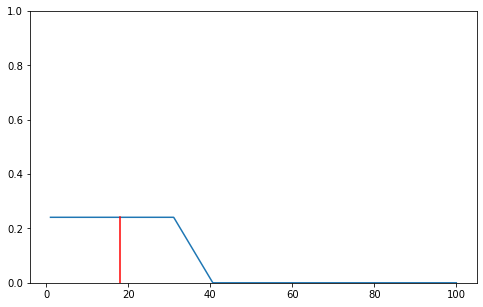

Grenoble -> 70


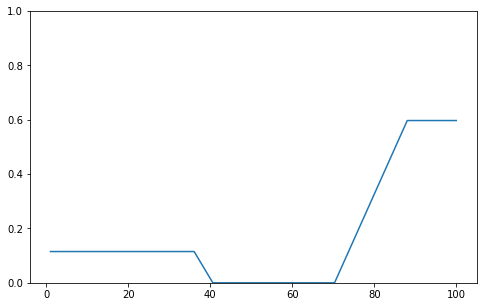

The Hague -> 78


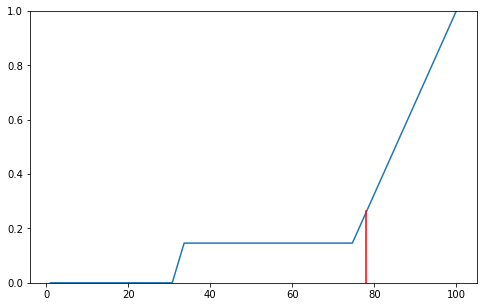

Dresden -> 66


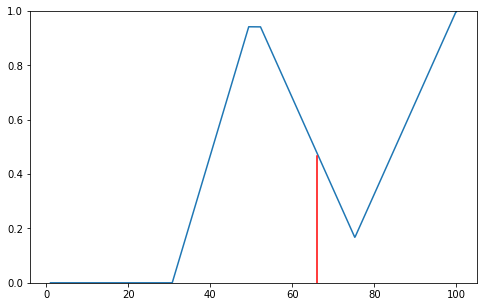

Adelaide -> 86


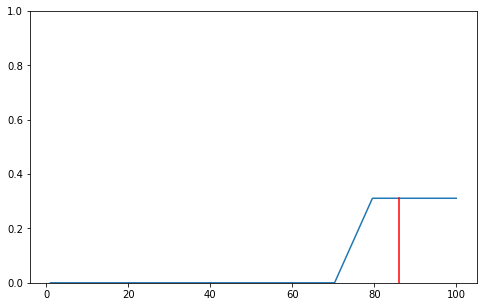

Cardiff -> 85


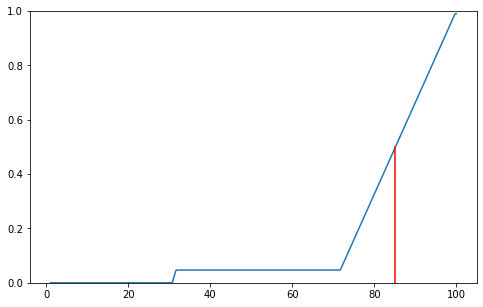

Leeds -> 72


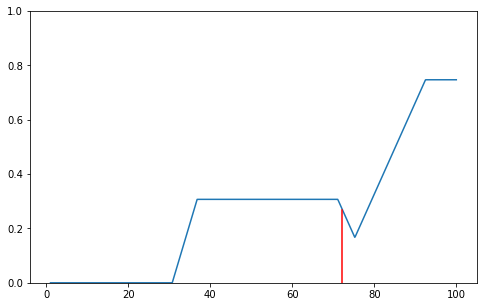

Albuquerque -> 53


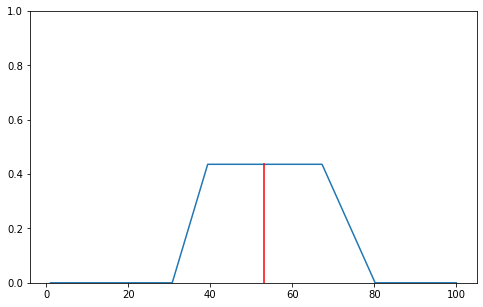

Mumbai -> 54


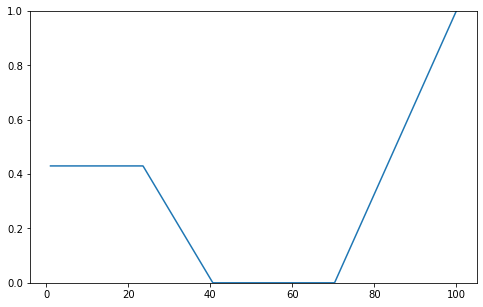

Gothenburg -> 67


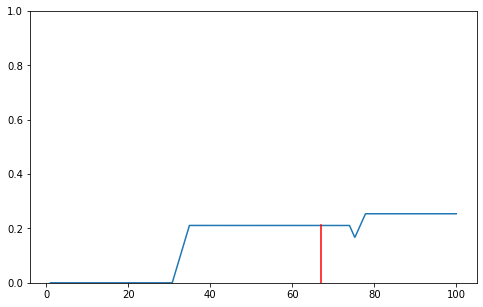

Bucharest -> 89


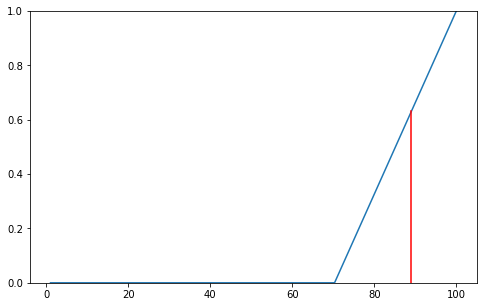

Cape Town -> 13


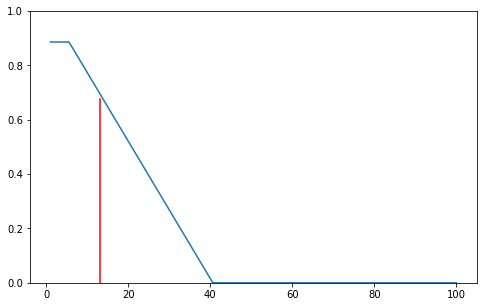

Nantes -> 89


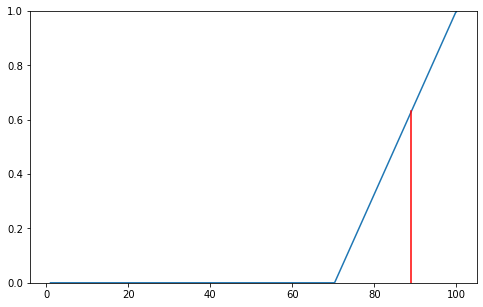

Melbourne -> 85


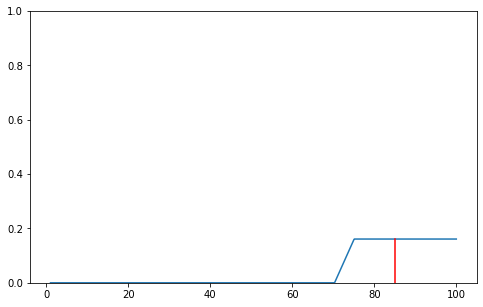

Oxford -> 89


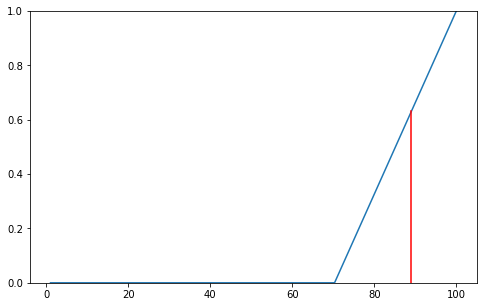

Tunis -> 89


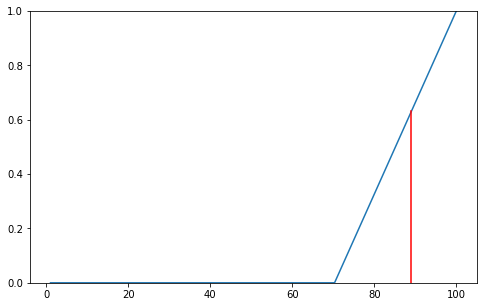

Lima -> 14


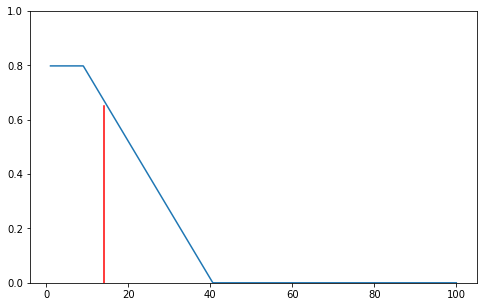

Detroit -> 41


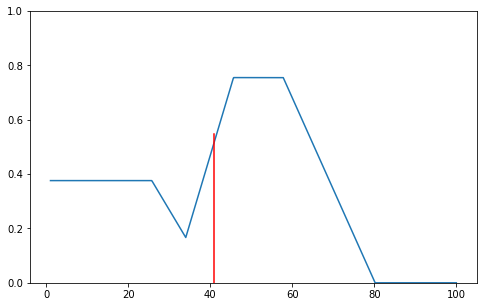

Ho Chi Minh City -> 35


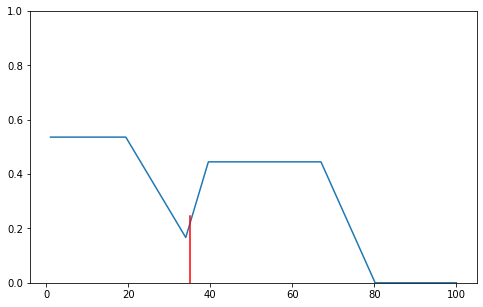

Tel Aviv -> 54


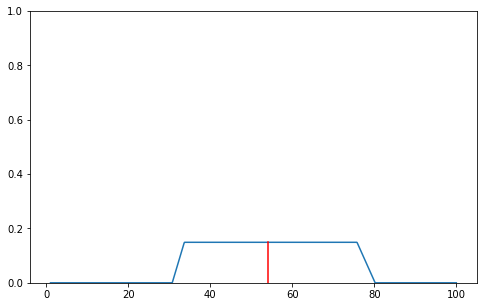

Doha -> 53


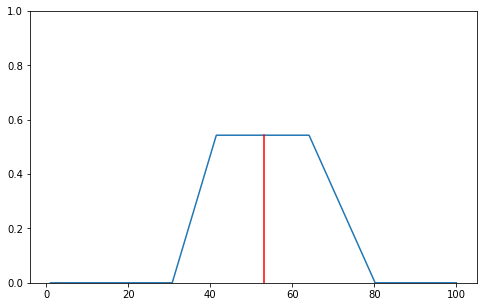

Halifax -> 85


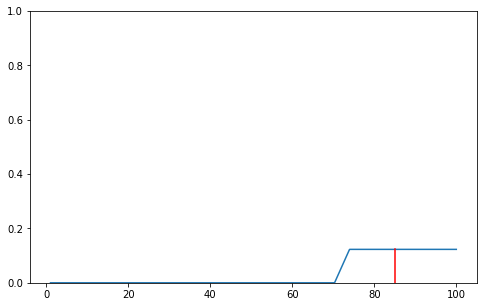

Hannover -> 89


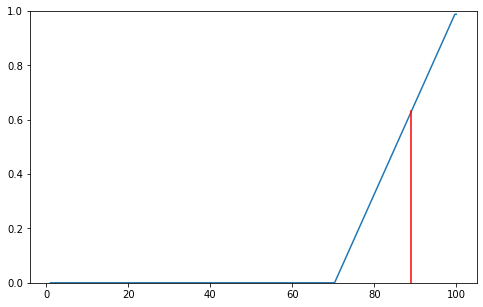

Barcelona -> 89


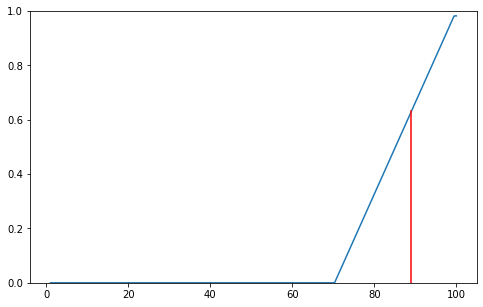

Glasgow -> 79


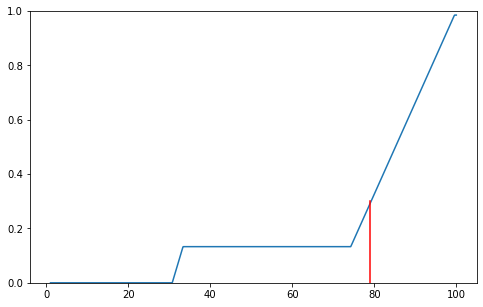

Osaka -> 89


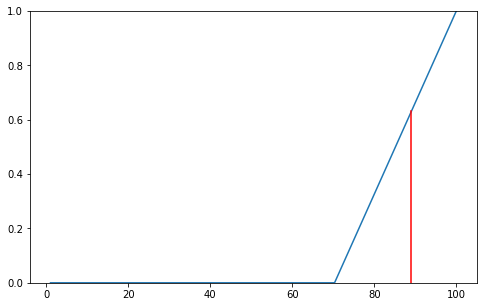

Bern -> 89


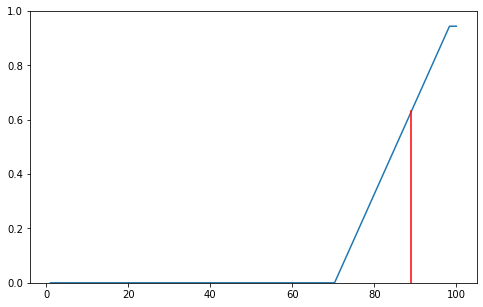

Munich -> 89


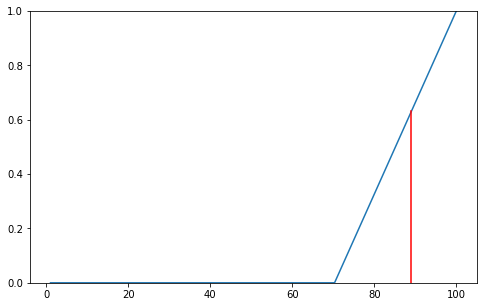

Rotterdam -> 78


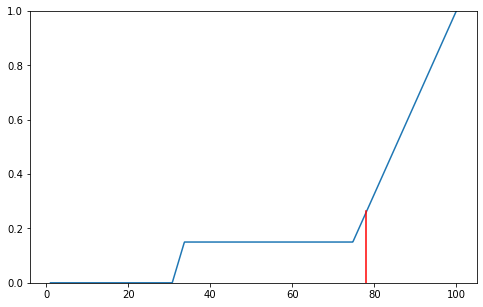

Memphis -> 13


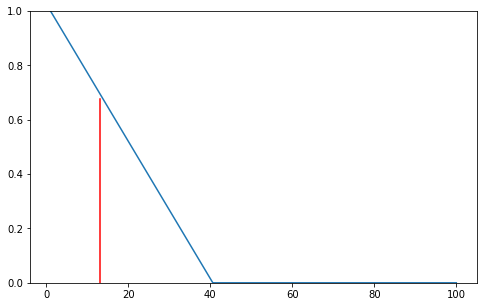

Charlotte -> 47


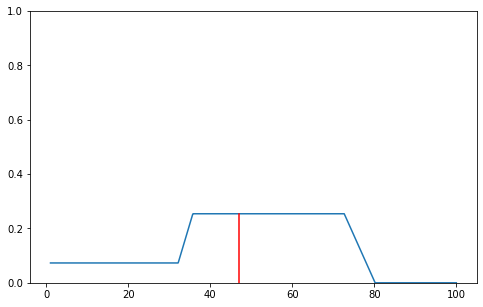

Rio De Janeiro -> 13


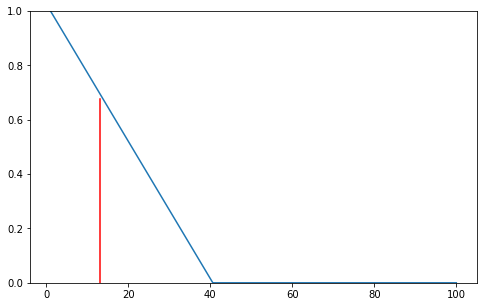

Turin -> 67


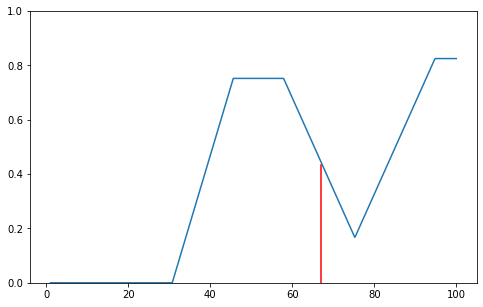

Santiago -> 73


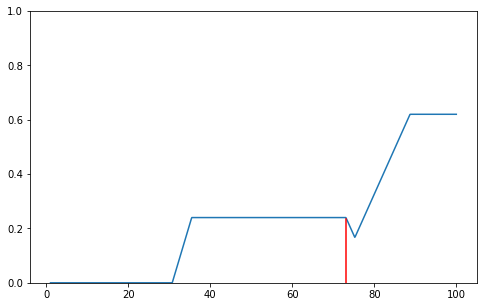

Turku -> 78


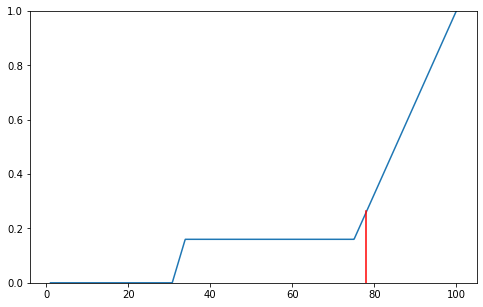

Wellington -> 88


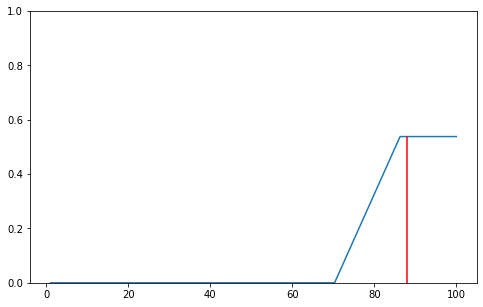

Tehran -> 14


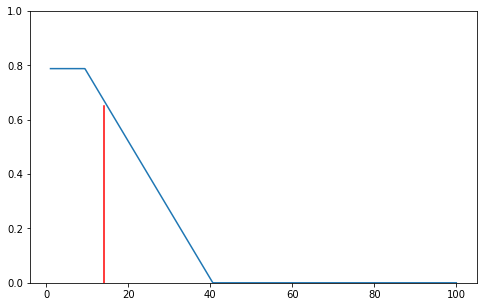

Seoul -> 89


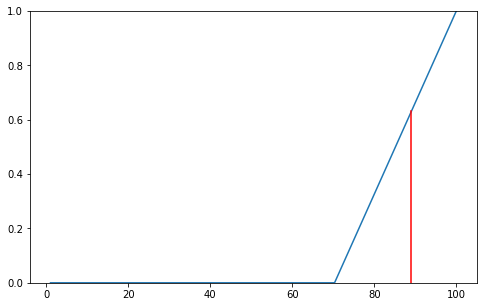

New Orleans -> 14


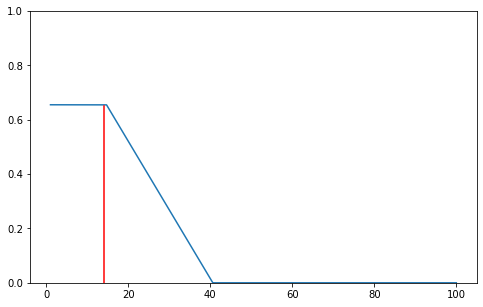

Tallinn -> 89


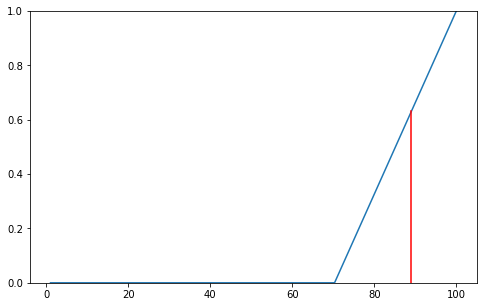

San Antonio -> 53


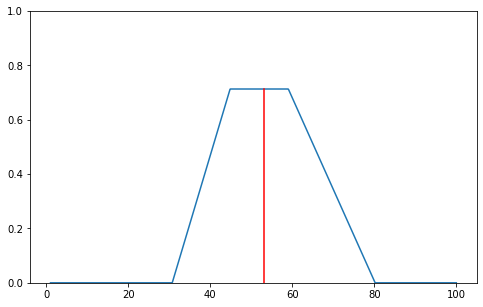

Phuket -> 17


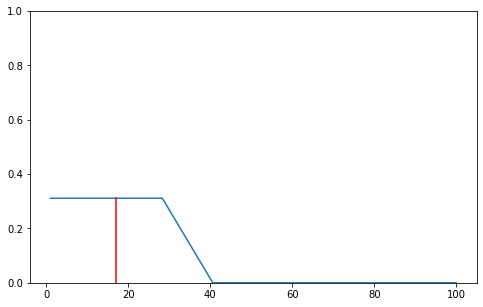

Galway -> 76


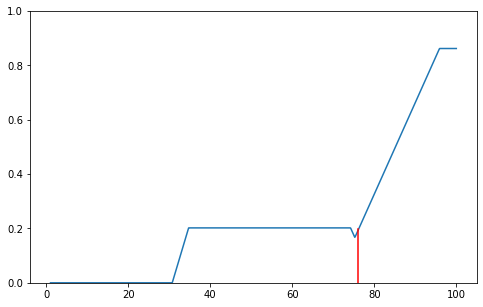

Hamburg -> 66


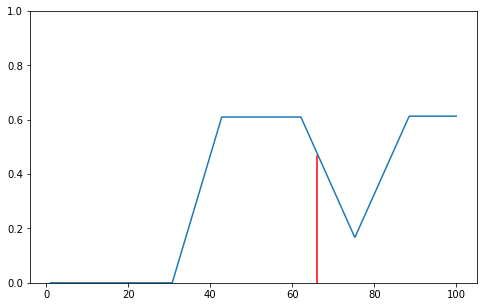

Singapore -> 89


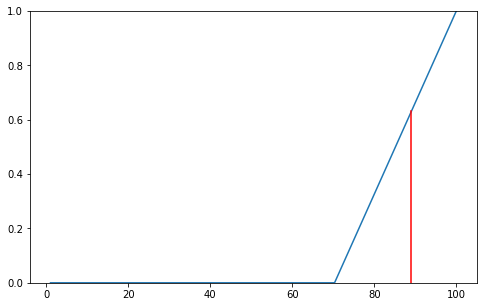

Prague -> 89


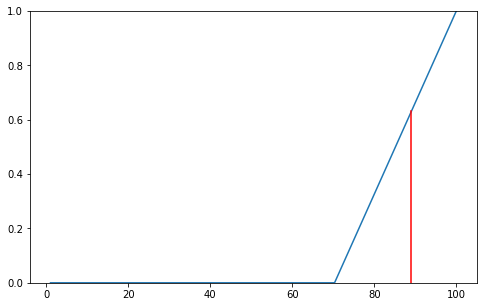

Paris -> 46


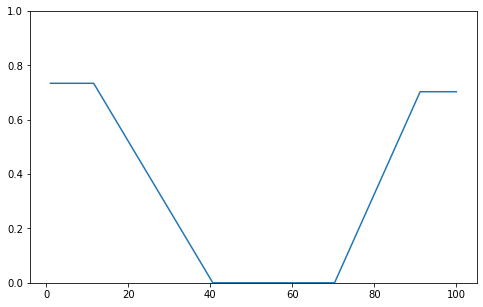

Jakarta -> 89


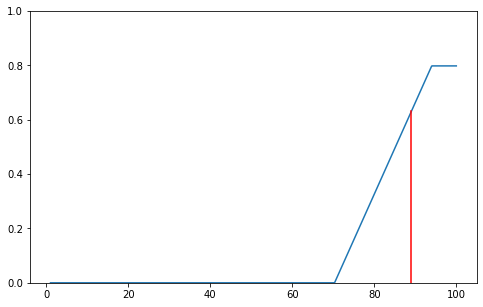

Ankara -> 89


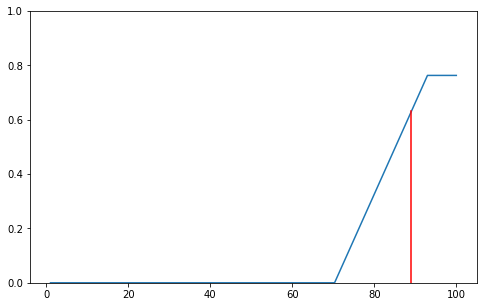

Stockholm -> 88


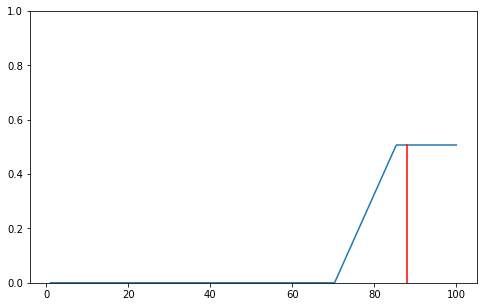

Anchorage -> 13


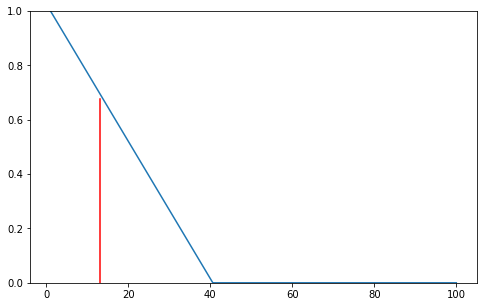

Marseille -> 89


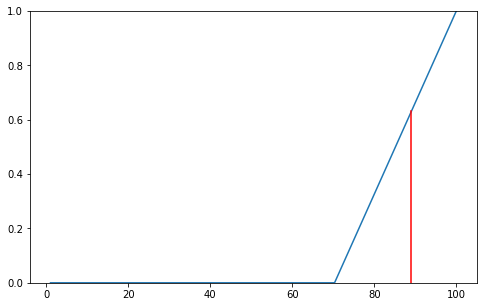

Seville -> 89


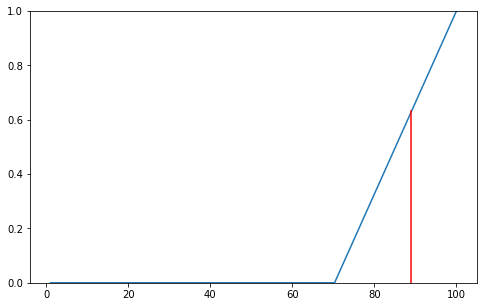

Stuttgart -> 67


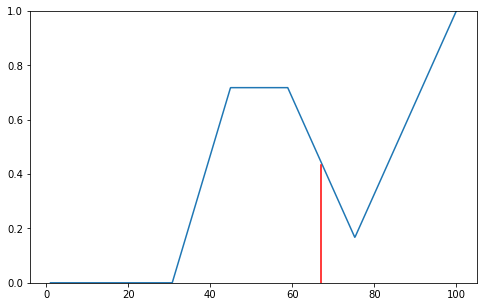

Leipzig -> 65


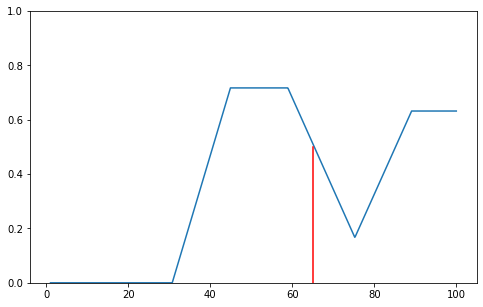

Bristol -> 89


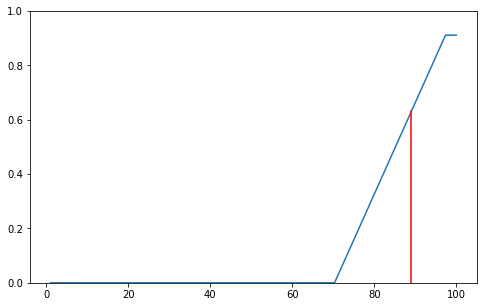

Dublin -> 86


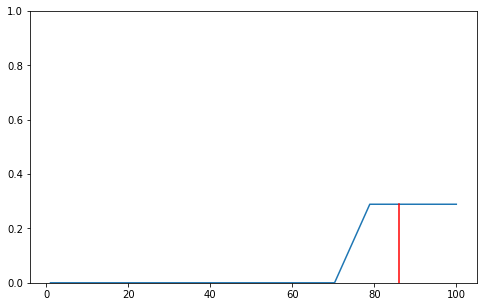

Porto -> 89


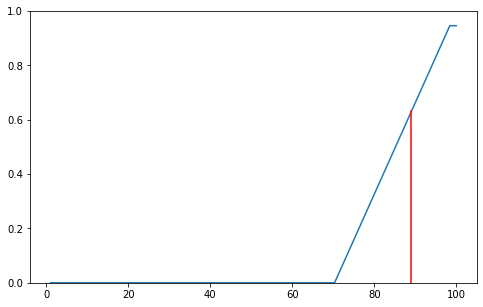

Phoenix -> 49


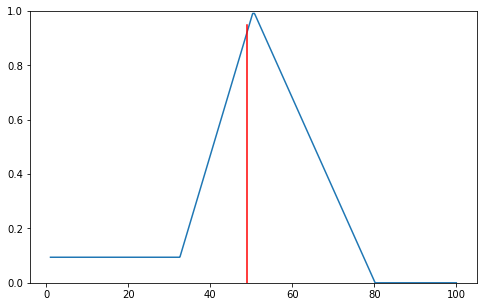

Bratislava -> 89


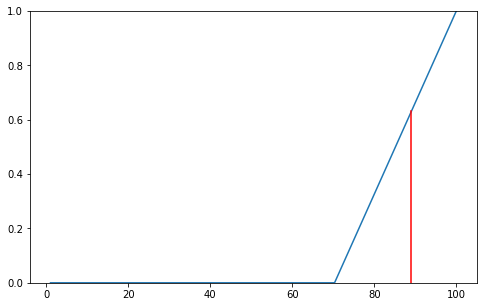

Rome -> 54


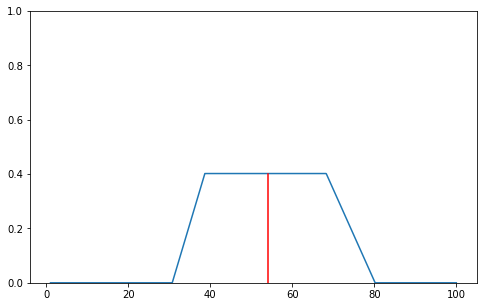

Nashville -> 14


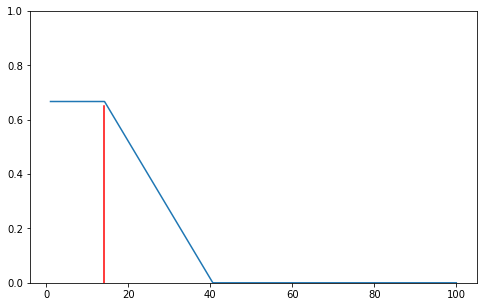

Tampere -> 80


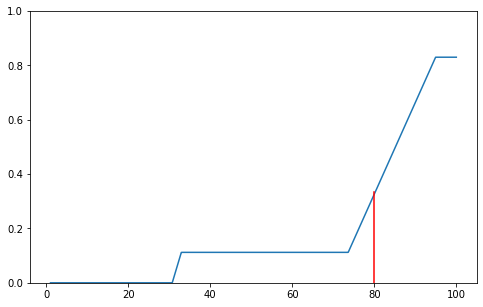

Bordeaux -> 89


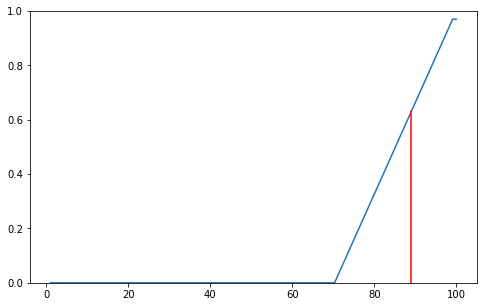

Minneapolis-Saint Paul -> 53


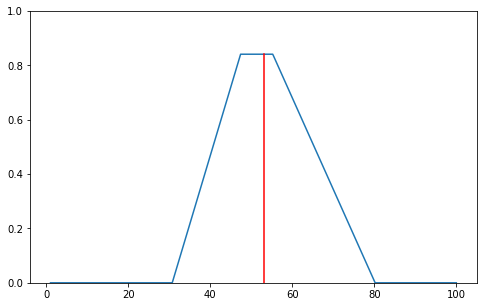

Dusseldorf -> 69


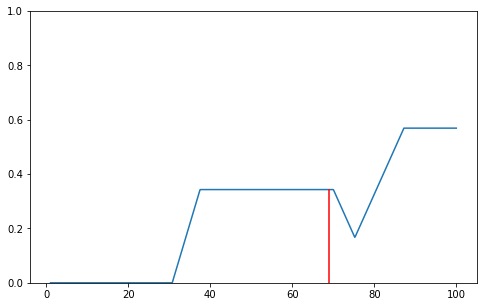

Copenhagen -> 89


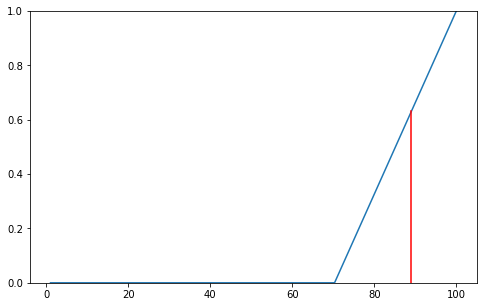

Milan -> 78


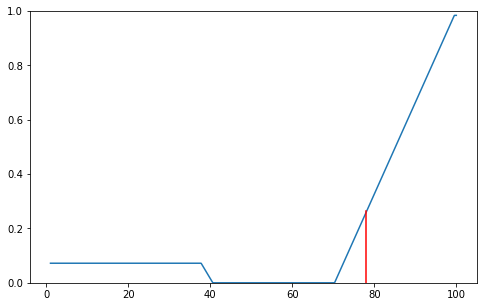

Aarhus -> 72


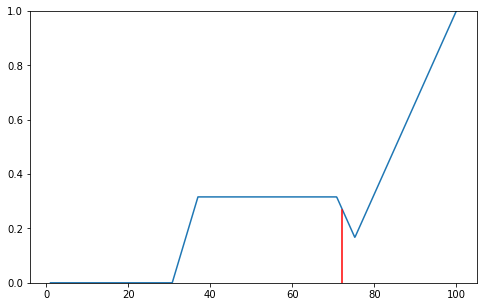

Santo Domingo -> 29


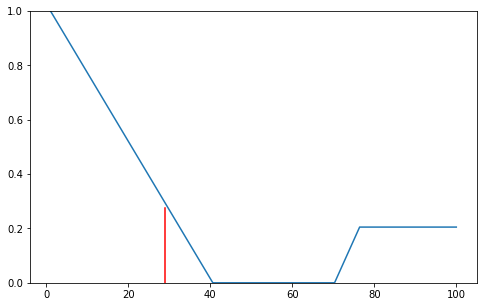

Warsaw -> 67


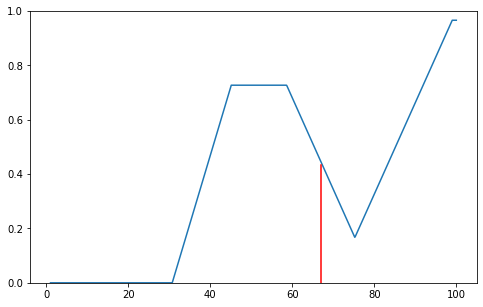

Medellin -> 89


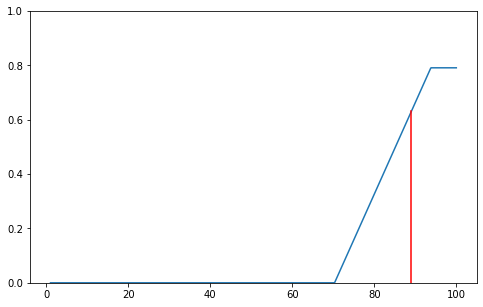

Pittsburgh -> 14


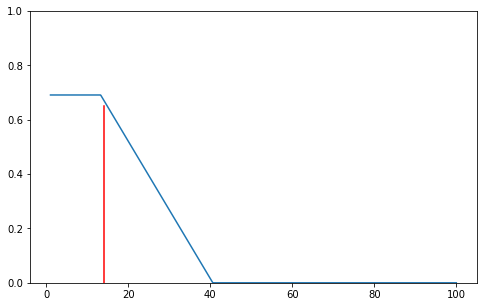

Boulder -> 54


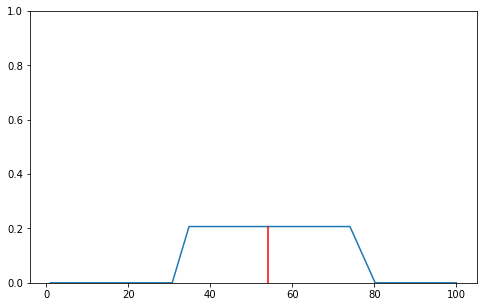

Skopje -> 89


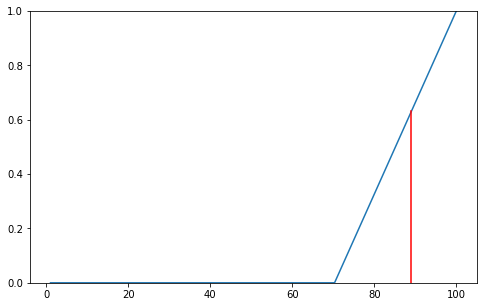

Seattle -> 35


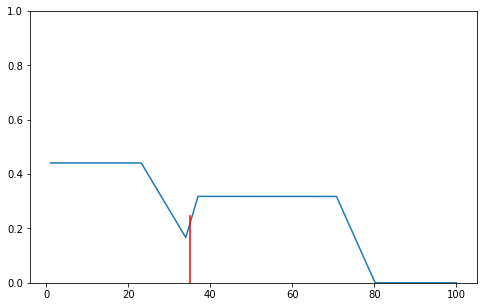

Philadelphia -> 13


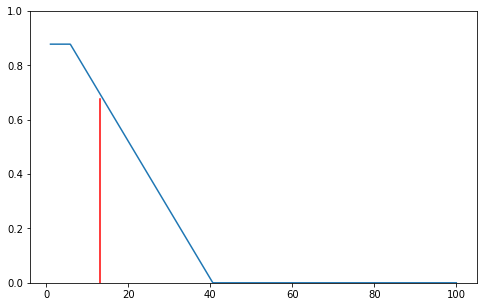

Porto Alegre -> 13


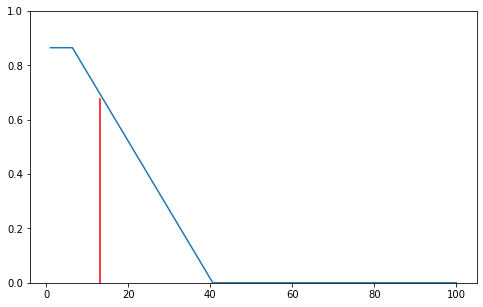

Almaty -> 89


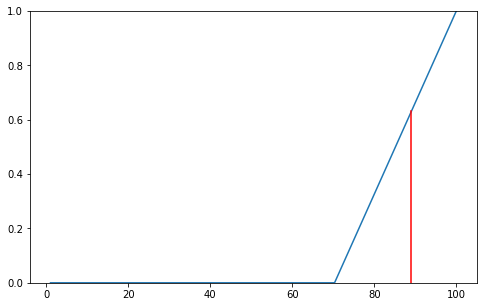

Austin -> 24


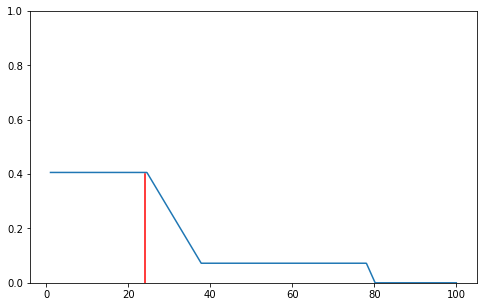

Los Angeles -> 14


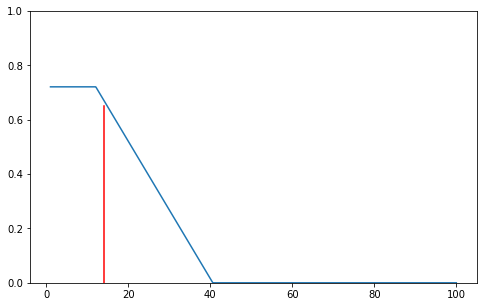

Chiang Mai -> 89


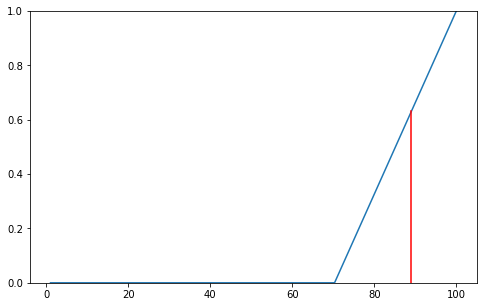

Birmingham -> 66


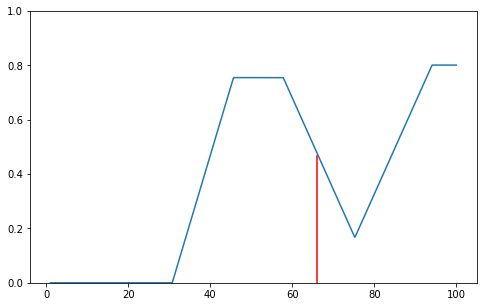

Montevideo -> 53


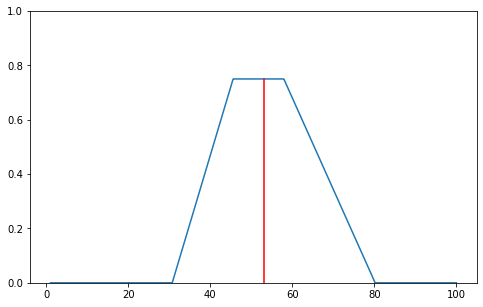

Chicago -> 16


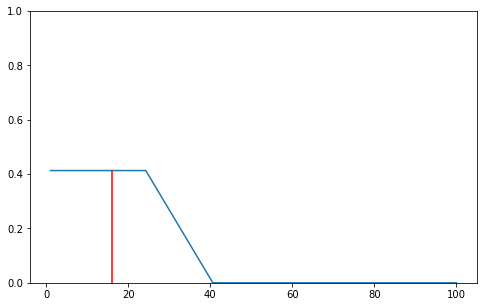

Gdansk -> 67


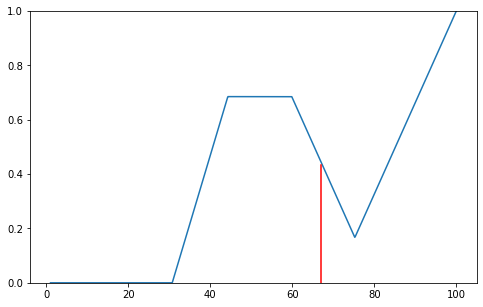

Columbus -> 53


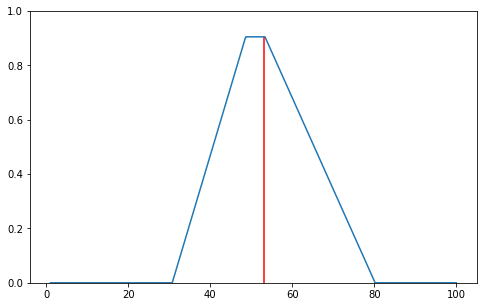

Utrecht -> 89


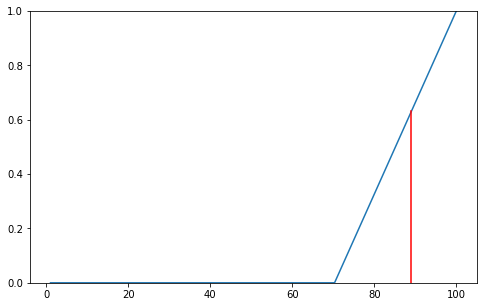

Belfast -> 69


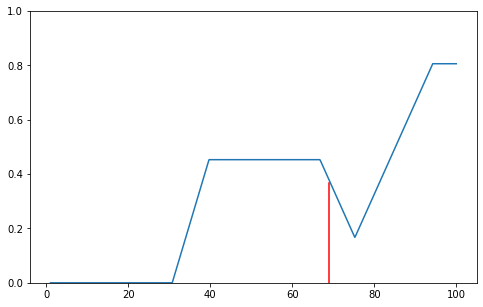

Shanghai -> 78


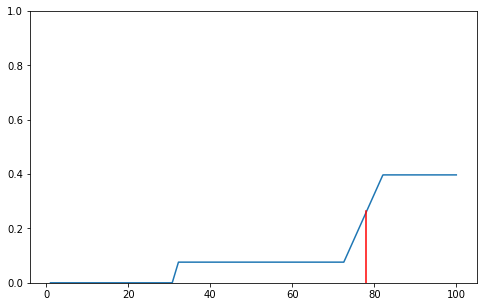

Florianopolis -> 18


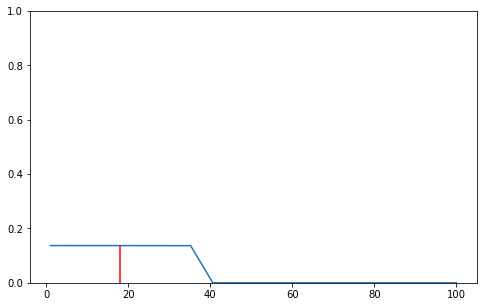

Honolulu -> 28


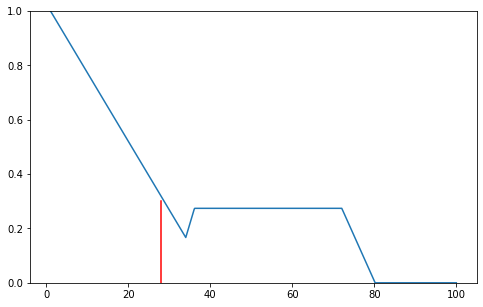

Innsbruck -> 89


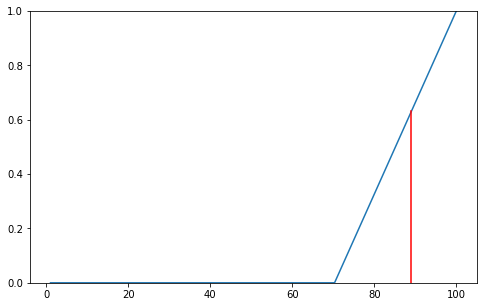

Uppsala -> 89


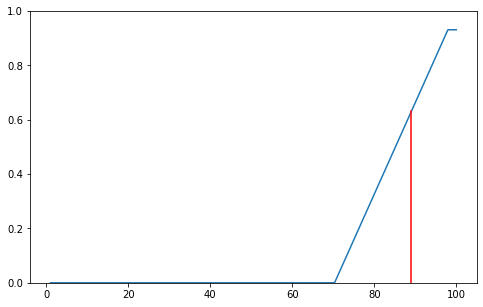

Charleston -> 13


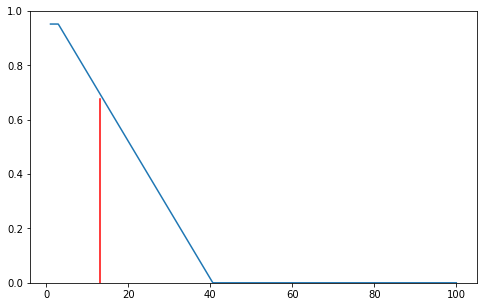

Ljubljana -> 79


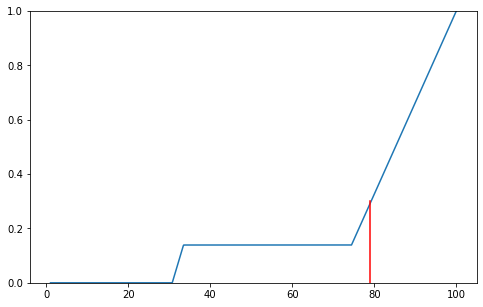

Delhi -> 54


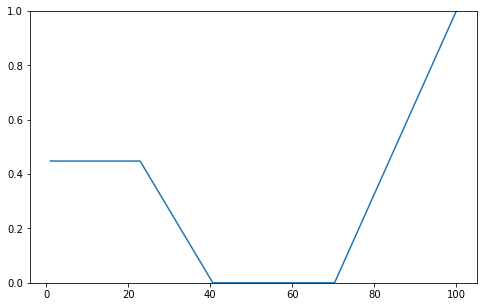

Tbilisi -> 52


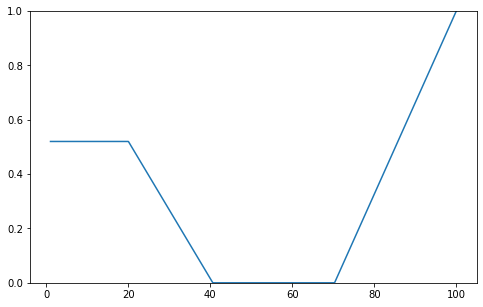

Guadalajara -> 54


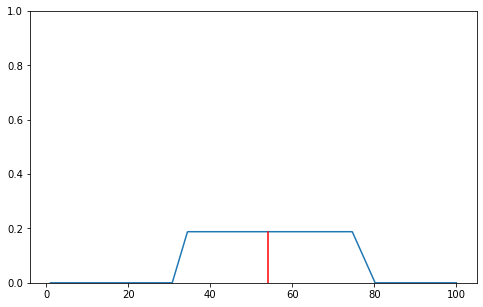

Luxembourg -> 69


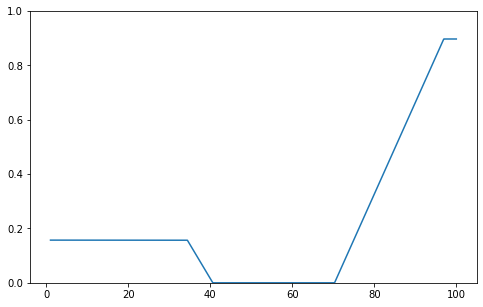

Saint Petersburg -> 89


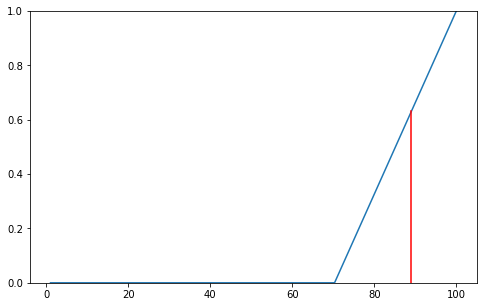

Raleigh -> 53


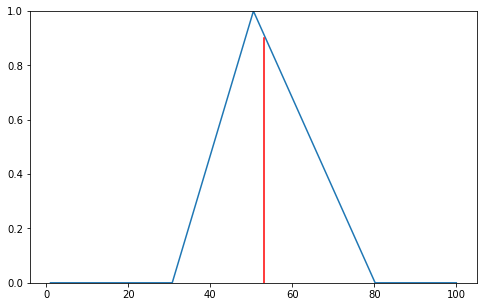

Berlin -> 67


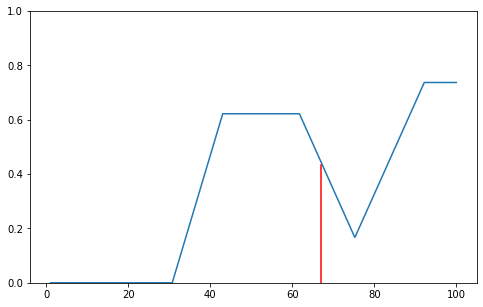

Amsterdam -> 89


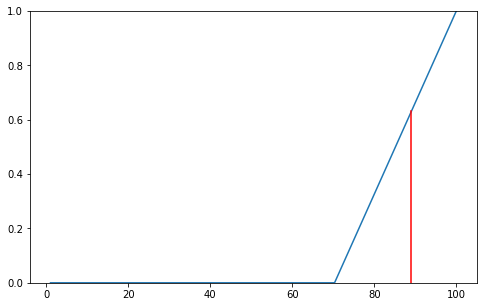

Bogota -> 41


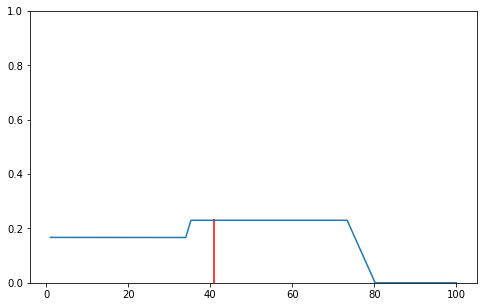

Richmond -> 53


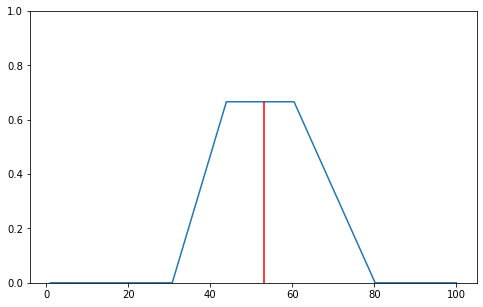

Cluj-Napoca -> 89


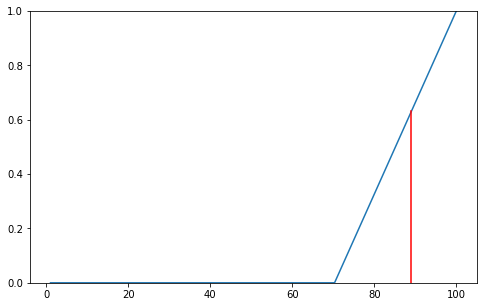

Tartu -> 89


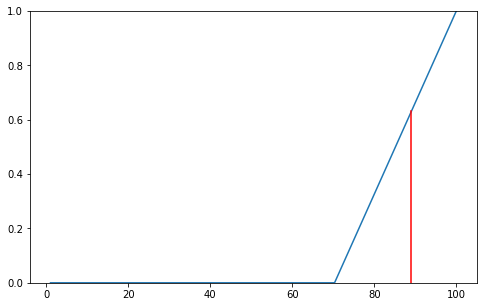

Belgrade -> 65


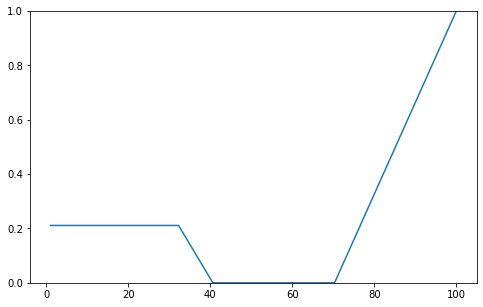

Florence -> 88


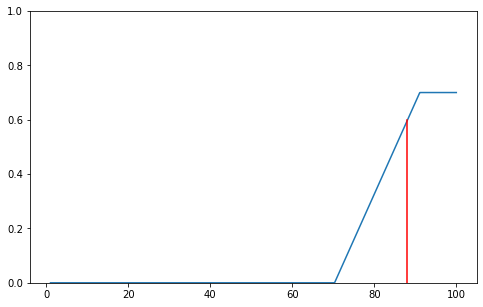

Tampa Bay Area -> 53


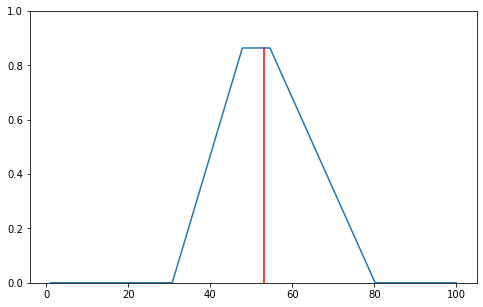

Nicosia -> 89


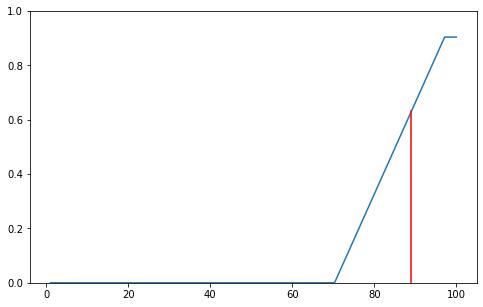

Riyadh -> 89


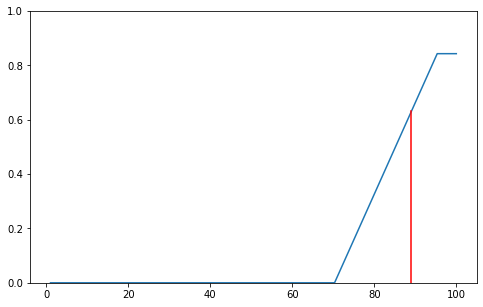

Beijing -> 67


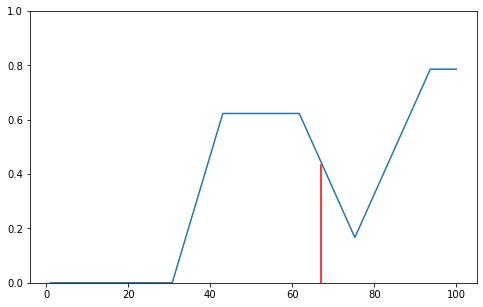

Geneva -> 89


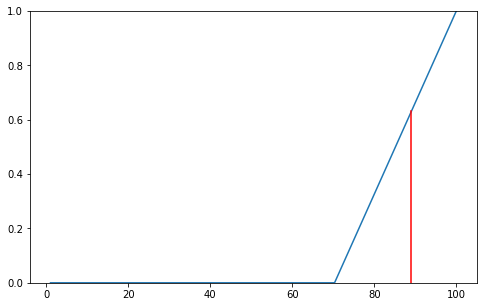

Dallas -> 18


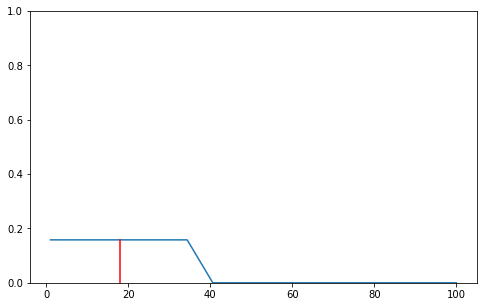

Beirut -> 35


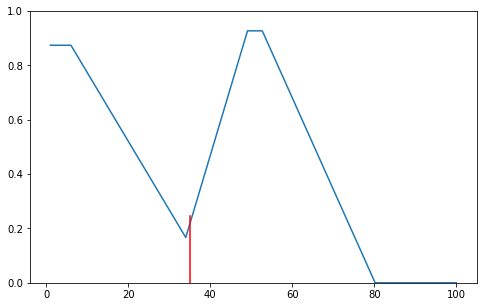

Taipei -> 73


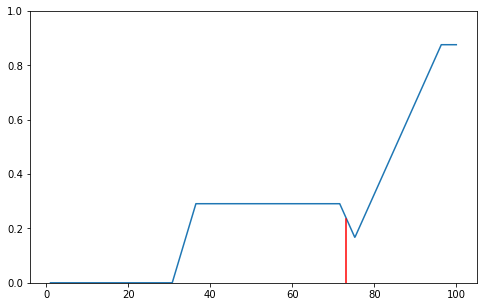

Cincinnati -> 53


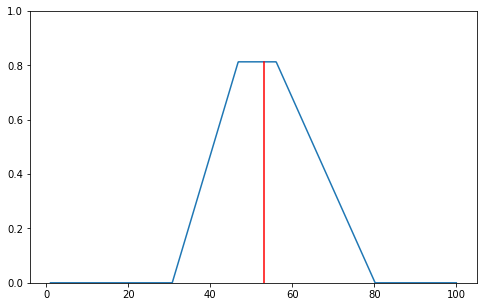

Vilnius -> 89


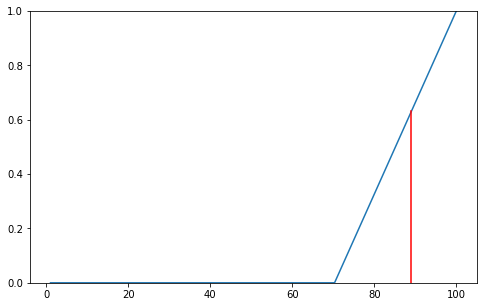

Krakow -> 67


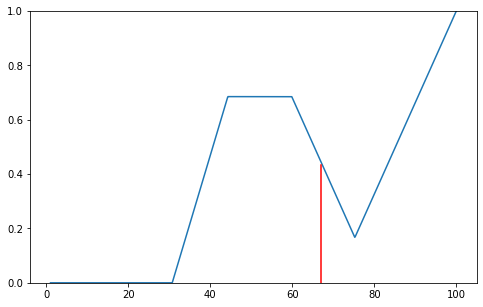

Ottawa -> 69


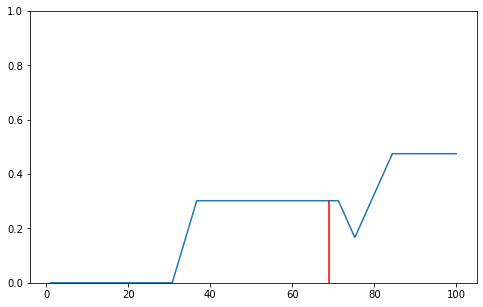

Portland -> 30


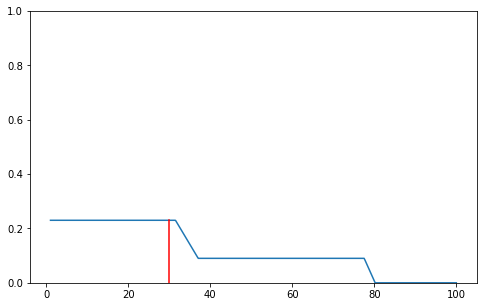

FOR NORM = ZadehNorm, DEFUZZIFICATION METHOD = centroid, THRESHOLD = 70


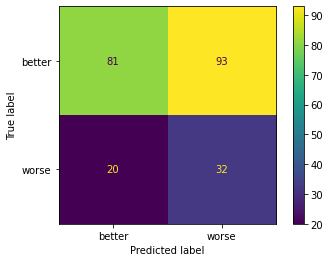

 > accuracy: 77.0%
 > recall: 71.7%
 > specificity: 82.3%
 > precision: 80.2%
----------------------------------------------------------------------------------


In [20]:
fuzzy_test = FuzzyTest(norm=ZadehNorm(), defuzzification_method='centroid')
result.append(fuzzy_test.run(fuzzy, pd.concat([a, b]), show_confusion_matrix=True, display=True))

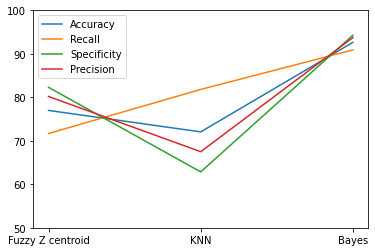

In [21]:
fig,ax = plt.subplots()
ax.set(ylim=(50,100))
sns.lineplot(x=['Fuzzy Z centroid', 'KNN', 'Bayes'], y=[accuracy[3], accuracy_k, accuracy_b])
sns.lineplot(x=['Fuzzy Z centroid', 'KNN', 'Bayes'], y=[recall[3], recall_k, recall_b])
sns.lineplot(x=['Fuzzy Z centroid', 'KNN', 'Bayes'], y=[specificity[3], specificity_k, specificity_b])
sns.lineplot(x=['Fuzzy Z centroid', 'KNN', 'Bayes'], y=[precision[3], precision_k, precision_b])
ax.legend(['Accuracy', 'Recall', 'Specificity', 'Precision'])

In [26]:
import Modules.softset as sft
print(sft.SoftSet.softset(a, b, 'Label'))

0.4852941176470588
